# 50 Years of Top 100
----

I'll be exploring Billboard Top 100 songs from years 1965-2015. These are the top 100 songs at the end of every year that Billboard ranks (not to be confused with Hot 100, which is weekly). 

I had two primary questions while working with this data -- what are the most common words seen in these top 100 songs and have popular songs become more repetitive? I hypothesized that words associated with "love" were most common in top 100 songs and that these popular songs got more repetitive.

Along with that, I also wanted to explore which artist appeared the most in the span of five decades as well as the frequency of specific words over the years as well.

### Table of Contents
0. [The Data](#section data)<br>
1. [Through the decades](#decades) |  [1965-1969](#60s)  |  [1970-1979](#70s)  |  [1980-1989](#80s)  |  [1990-1999](#90s)  |  [2000-2010](#00s)  |  [2010-2015](#recent) |  [Overall](#overall) <br>
2. [Frequency of words across each year](#section 2)<br>
3. [Repetition across popular songs](#repeat)<br>
4. [Who appeared the most on the Top 100?](#whomst)<br>
5. [Your favorite artist, their favorite words](#WORDS)<br><br>


**Dependencies:**

In [ ]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
from matplotlib import cm
donut_plot_colors = [i for i in cm.plasma(np.arange(0, 255, 13))]

import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import nltk

----

## The Data<a id='section data'></a>

I'm using lyrics of the Billboard Top 100 songs from 1965-2015 [(credit)](https://github.com/walkerkq/musiclyrics) for this exploration. It contains the top 100 songs every year for five decades, with the artist and lyrics as well. Some lyrics are missing from this dataset, which I did not think made a big difference in the resulting analysis, but will result in small discrepancies.

In [2]:
lyrics = pd.read_csv('billboard.csv', encoding = "latin1")
lyrics.head()

,Rank,Song,Artist,Year,Lyrics,Source
0,1,wooly bully,sam the sham and the pharaohs,1965,sam the sham miscellaneous wooly bully wooly b...,3.0
1,2,i cant help myself sugar pie honey bunch,four tops,1965,sugar pie honey bunch you know that i love yo...,1.0
2,3,i cant get no satisfaction,the rolling stones,1965,,1.0
3,4,you were on my mind,we five,1965,when i woke up this morning you were on my mi...,1.0
4,5,youve lost that lovin feelin,the righteous brothers,1965,you never close your eyes anymore when i kiss...,1.0


Throughout this notebook, I'll be using `scikit-learn` vectorizers and the stop word set, to which I have added more words to because many of these songs have included these words that did not contribute much meaning to the analysis. 

In [3]:
from sklearn.feature_extraction import stop_words

more_stop_words = set(['im', 'like', 'it', 'dont', 'aint', 'ive', 'ill', 
                       'wont', 'gonna', 'youre','just','got','theres',
                       'let','oh', 'come', 'want', 'good','make', 'cause',
                       'shes', 'hes', 'lets', 'theyll', 'youll', 'youve',
                       'id', 'thats', 'way', 'wanna', 'know', 'imma', 'theyre', 
                       'youd', 'ooh', 'ityoure'])

stop = stop_words.ENGLISH_STOP_WORDS.union(more_stop_words)

While working with the data, I wrote some functions that would help with declutter each cell, since I did use the same code a lot in the beginning of this notebook.

In [4]:
#zipping the feature_names (the words in each song) and fitted_and_transformed (the corresponding count)
#which I then sort to have the find the highest count and then take the top 20 words and their counts.
def top_20_words(fitted_and_transformed, feature_names):
    sorted_words = sorted(list(zip(feature_names, np.asarray(fitted_and_transformed.sum(axis=0)).ravel())), 
                               key=lambda x: x[1], reverse=True)
    words, count = [i[0] for i in sorted_words[:20]], [i[1] for i in sorted_words[:20]]
    return words, count

#In the following function, I plot the resulting words and their counts (from top_20_words) in a horizontal bar chart. 
def plot_top_20(words, count, plot_title):
    plt.subplots(dpi=300)
    sns.set(font_scale=1)
    top_words = pd.DataFrame(data={'Word' : words, 'Count': count}).take([1, 0], axis=1)
    plt.title(plot_title)
    sns.barplot(x = top_words['Count'], y=top_words['Word'], palette=("plasma"));

#This function was supposed to plot a donut plot, but I chose not to use it. Leaving it here for future use though.
def plot_donut(words, counts, decade ,color=donut_plot_colors):
    plt.figure(dpi=80, figsize=(7,7))
    my_circle=plt.Circle((0,0), 0.75, color='white')
    plt.pie(count1, labels=list(zip(words, counts)), colors=color)
    p=plt.gcf()
    p.gca().add_artist(my_circle)
    plt.title('Word Count of Songs from the '+ str(decade) +'s')
    plt.show()

#This function displays the topic number and the following words.
def show_sk_topics(model, feature_names, n_top_words):
    for num_topic, topic in enumerate(model.components_):
        words = np.argsort(topic)[::-1][:n_top_words]
        print('Topic ' + str(num_topic) + ':')
        print(' '.join([feature_names[i] for i in words]))
        print()

#Wasn't used.
def display_scores(vectorizer, tfidf_result):
    scores = sorted(zip(vectorizer.get_feature_names(), np.asarray(tfidf_result.sum(axis=0)).ravel()),
                    key=lambda x: x[1], reverse=True)
    for item in sorted_scores[:20]:
        print("{0:10} Score: {1}".format(item[0], item[1]))

----
# Through the Decades<a id='decades'></a>

I approached each decade similarly by first sorting the lyrics and only keeping the lyrics that weren't null values. Then, I implemented a topic model using non-negative matrix factorization (NMF) to see any underlying topics within a certain decade (which worked better in some decades than others). Lastly, I plotted the 20 most used words in a decade and plotted the words using `plot_top_20`.

----
## 1965-1969<a id='60s'></a>

In [5]:
decade1lyrics = lyrics[lyrics['Year'] < 1970]['Lyrics'].values
decade1lyrics = [i for i in decade1lyrics if type(i) == str] #Handle NaN values.

#max_df = .90, don't want words that are in ALL songs, or topics might get fuzzy.
tfidf1_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, stop_words=stop)
tfidf1 = tfidf1_vectorizer.fit_transform(decade1lyrics)
decade1_fn = tfidf1_vectorizer.get_feature_names()

decade1NMF = NMF(n_components=5, random_state=1, init='nndsvd').fit(tfidf1)

show_sk_topics(decade1NMF, decade1_fn, 15)

Topic 0:
love need heart tell say hold true darling wait think world sweet feel forever long

Topic 1:
baby hey stop hear real lovin say sweet does thank pretty friends ooo ya true

Topic 2:
girl yeah little time man mind hey world place day away woman better right home

Topic 3:
instrumental little girl feel break affection green tambourine feels fade bad loves away sweet ride

Topic 4:
na world hey bop exactly midnight leave help showed say mind little cloud fell woman



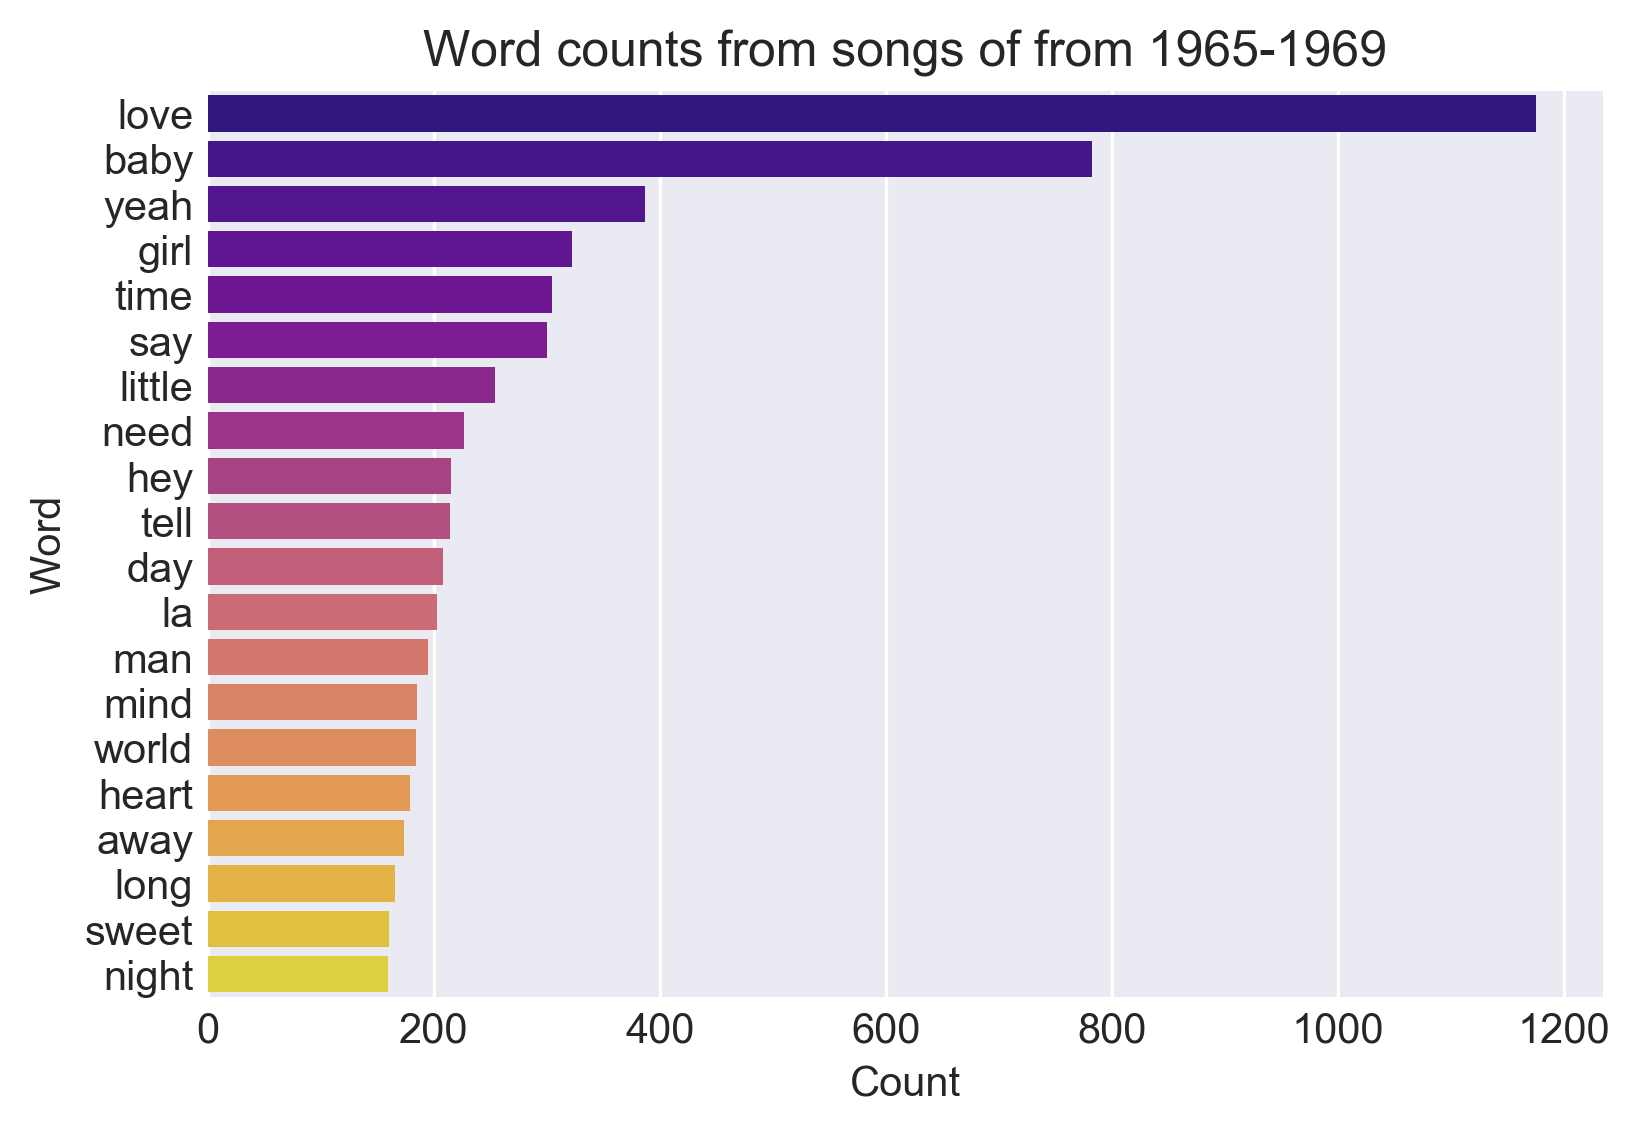

In [6]:
count_vec1 = CountVectorizer(max_df=0.95, min_df=2, stop_words=stop)
cv1 = count_vec1.fit_transform(decade1lyrics)
cv_fn1 = count_vec1.get_feature_names()
#kept LDA model+parameters for future use
#decade1LDA = LatentDirichletAllocation(n_components=6, batch_size=29, learning_decay=.7, max_iter=130, learning_method='online').fit(cv1)

words1, count1 = top_20_words(cv1, cv_fn1)
plot_top_20(words1, count1, 'Word counts from songs of from 1965-1969')

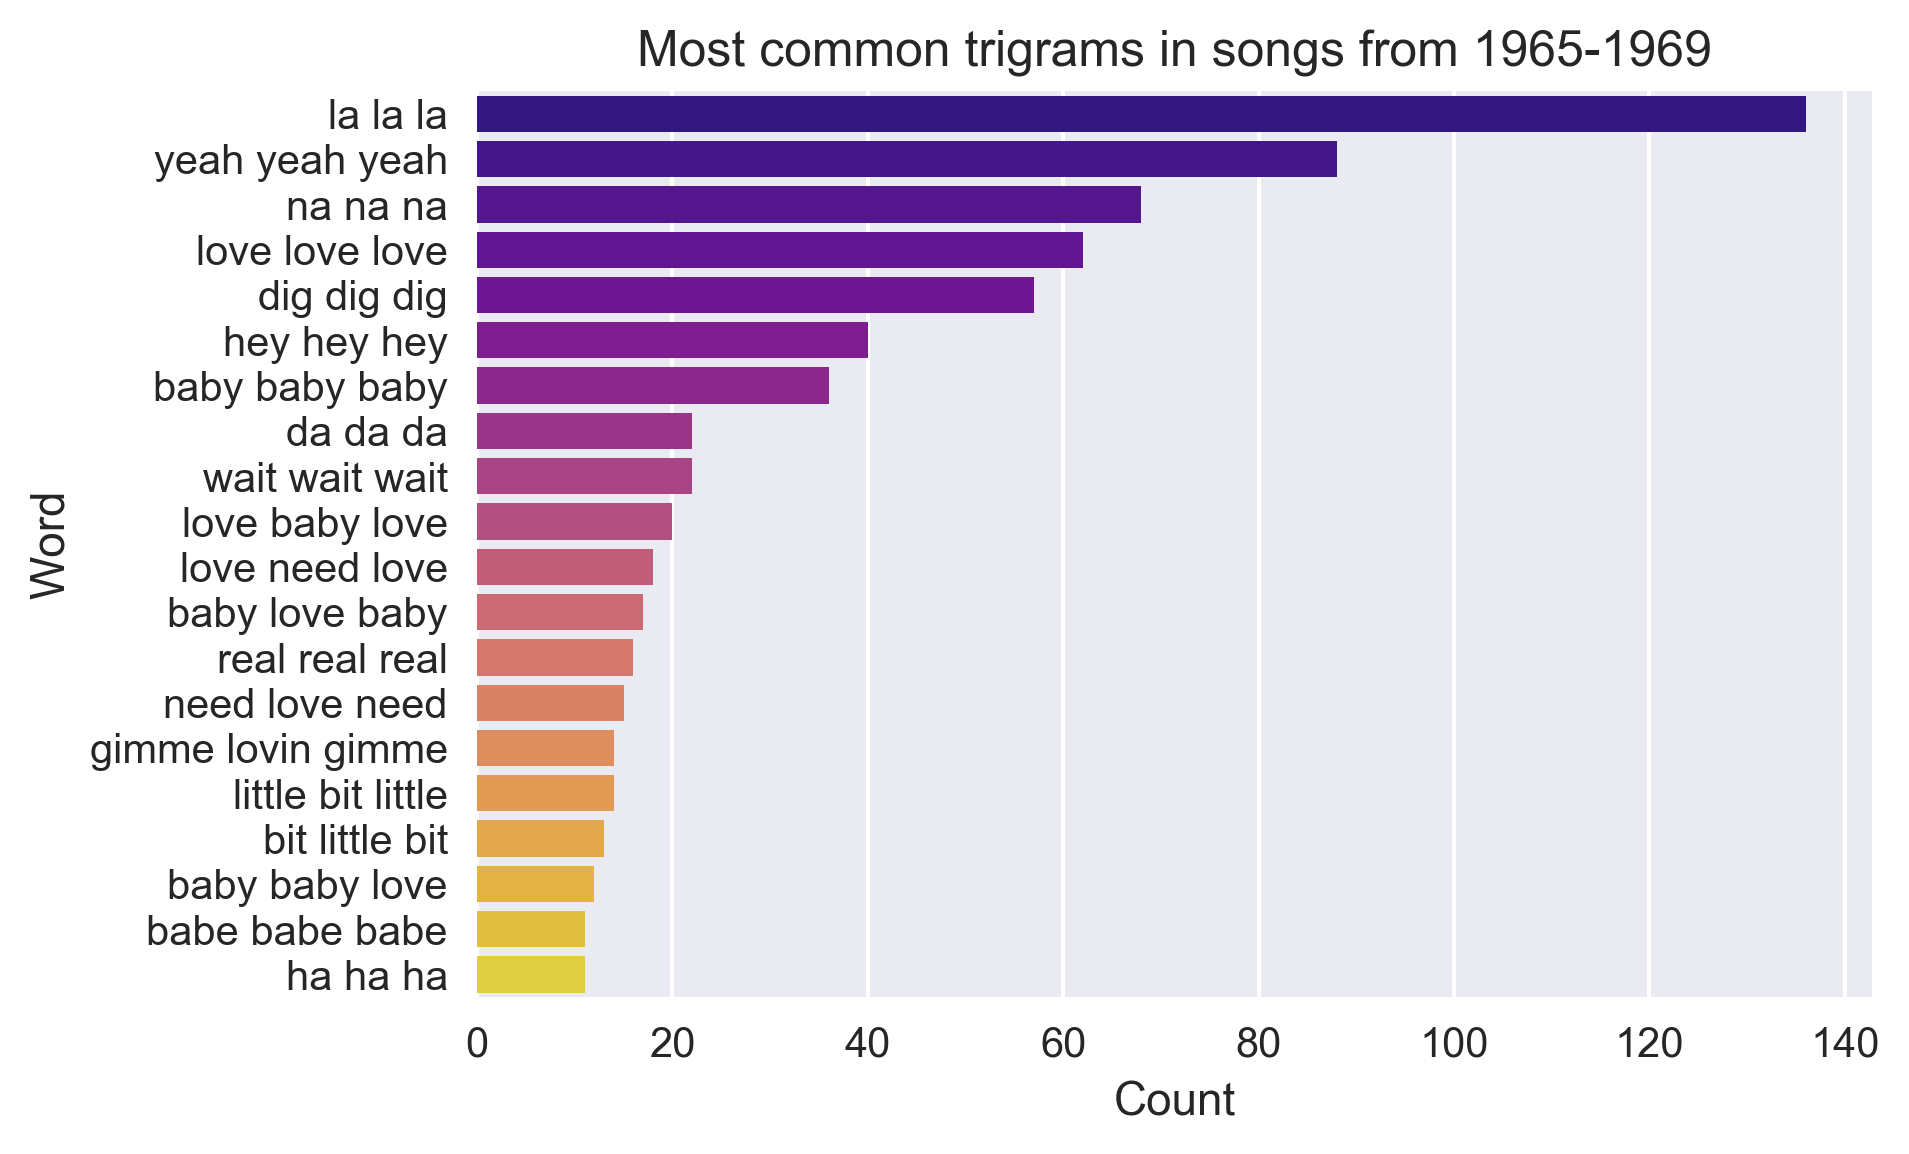

In [7]:
count_vec1_3 = CountVectorizer(max_df=1.0, min_df=2, stop_words=stop, ngram_range=(3, 3))
cv1_3 = count_vec1_3.fit_transform(decade1lyrics)
cv_fn1_3 = count_vec1_3.get_feature_names()

words1_3, count1_3 = top_20_words(cv1_3, cv_fn1_3)
plot_top_20(words1_3, count1_3, 'Most common trigrams in songs from 1965-1969')

Topics from this range of years were not extremely elucidating, as many of the underlying topics only presented similar words pertaining to love, relationships, and the like.

Love, baby, yeah, girl, and time are the five most common words from 1965-1969. These words are, in a way, associated with "love." Looking at the most common three-words phrases (trigrams), many of them contain words associated with love.

----
## 1970-1979<a id='70s'></a>

As stated earlier, I'll go through the same process for each decade.

In [8]:
decade2lyrics = lyrics[lyrics['Year'].between(1970, 1979, inclusive=True)]['Lyrics'].values
decade2lyrics = [i for i in decade2lyrics if type(i) == str]

tfidfv2 = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=stop)
tv2 = tfidfv2.fit_transform(decade2lyrics)
tv2_fn = tfidfv2.get_feature_names()

decade2NMF = NMF(n_components=6, random_state=1, init='nndsvd').fit(tv2)

show_sk_topics(decade2NMF, tv2_fn, 13)

Topic 0:
love feel fall sweet need heart right tell world little shine hold turn

Topic 1:
time say yeah day night life away man said long tell right home

Topic 2:
baby lovin dance feel hey right yeah girl really ya little hold say

Topic 3:
instrumental wild fly lady thing right eyed whatcha ride robin beggin pretty groovy

Topic 4:
boogie dance dancing woman disco jungle music nightlife yeah nights round wonderland high

Topic 5:
la da sing hot friends song new hey world funk mend brand thing



Compared to the previous decade, the topics of songs in the 70s indicate that this decade had a lot of disco songs or songs to dance to on the top 100! We see that topic 0 and 2 are about love, but overall, the topics for this decade are more varied and do not to seem to be exclusively about love.

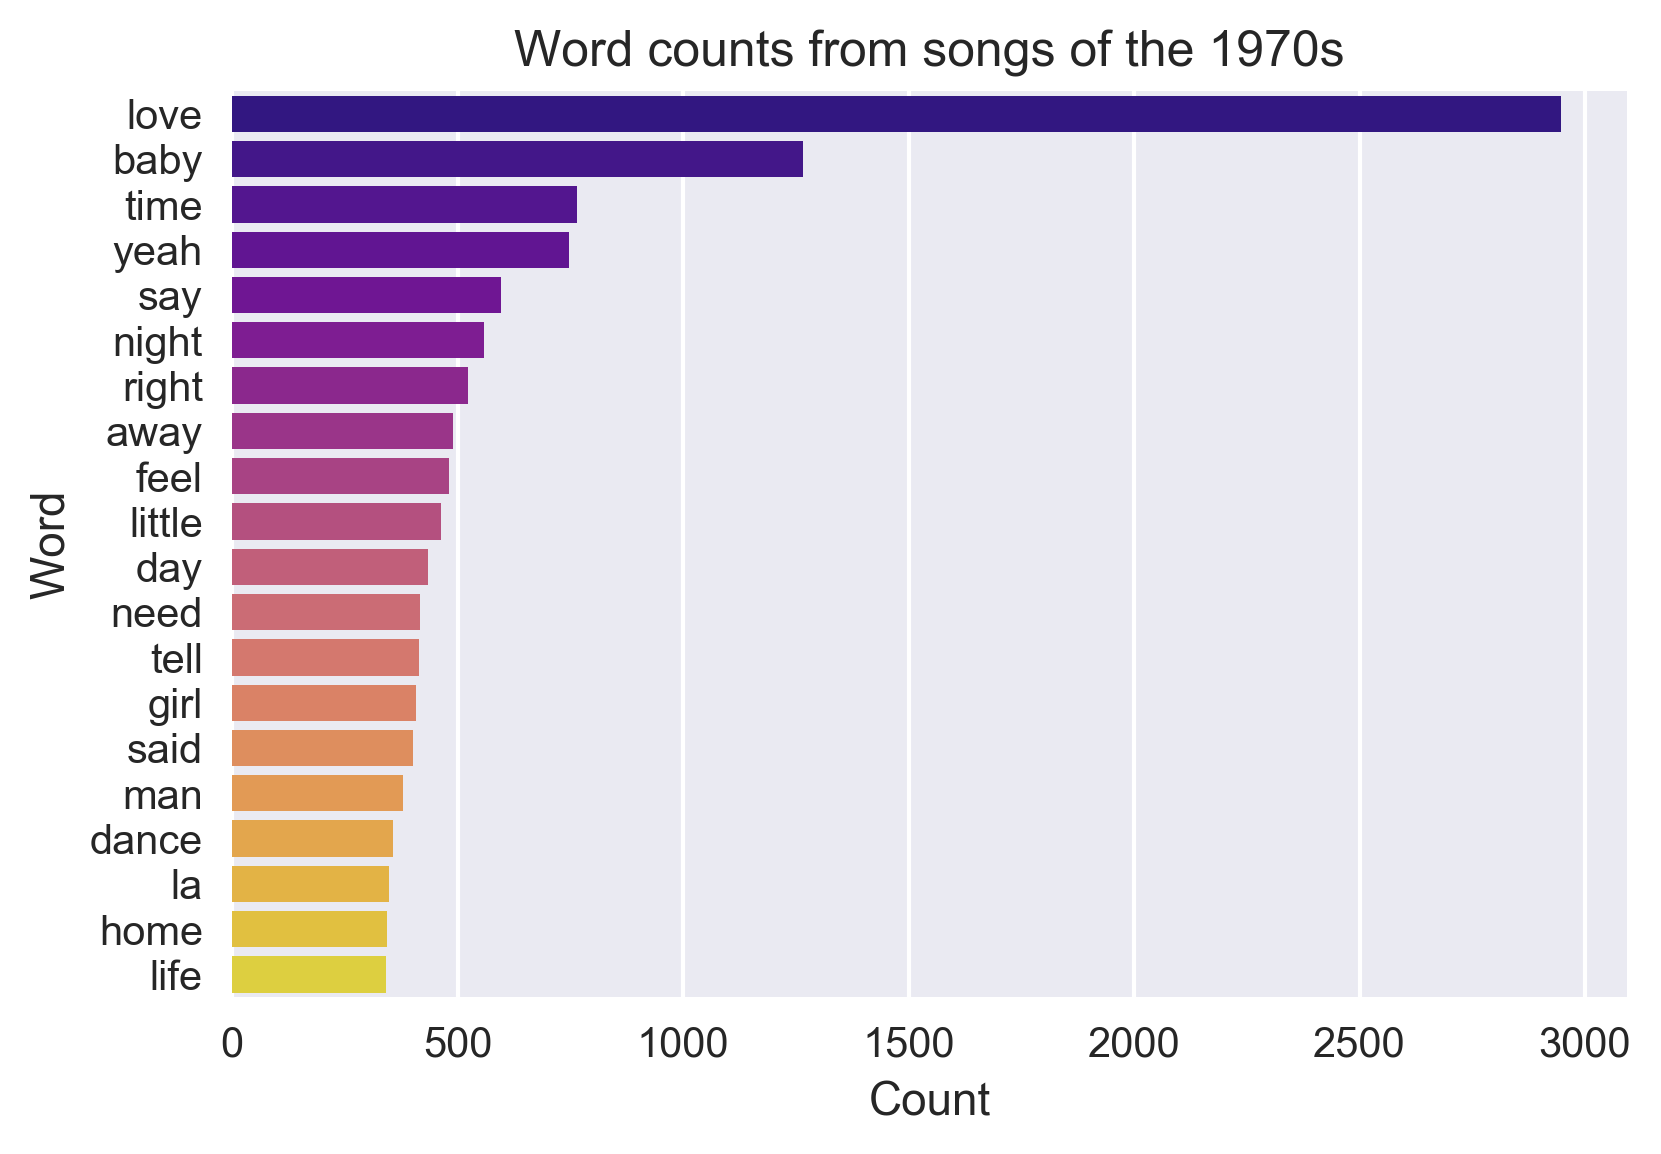

In [9]:
count_vec2 = CountVectorizer(max_df=1.0, min_df=2, stop_words=stop)
cv2 = count_vec2.fit_transform(decade2lyrics)
cv_fn2 = count_vec2.get_feature_names()
#decade2LDA = LatentDirichletAllocation(n_components=5, batch_size=50, learning_decay=.65, max_iter=50, learning_method='online').fit(cv2)

words2, count2 = top_20_words(cv2, cv_fn2)
plot_top_20(words2, count2, 'Word counts from songs of the 1970s')

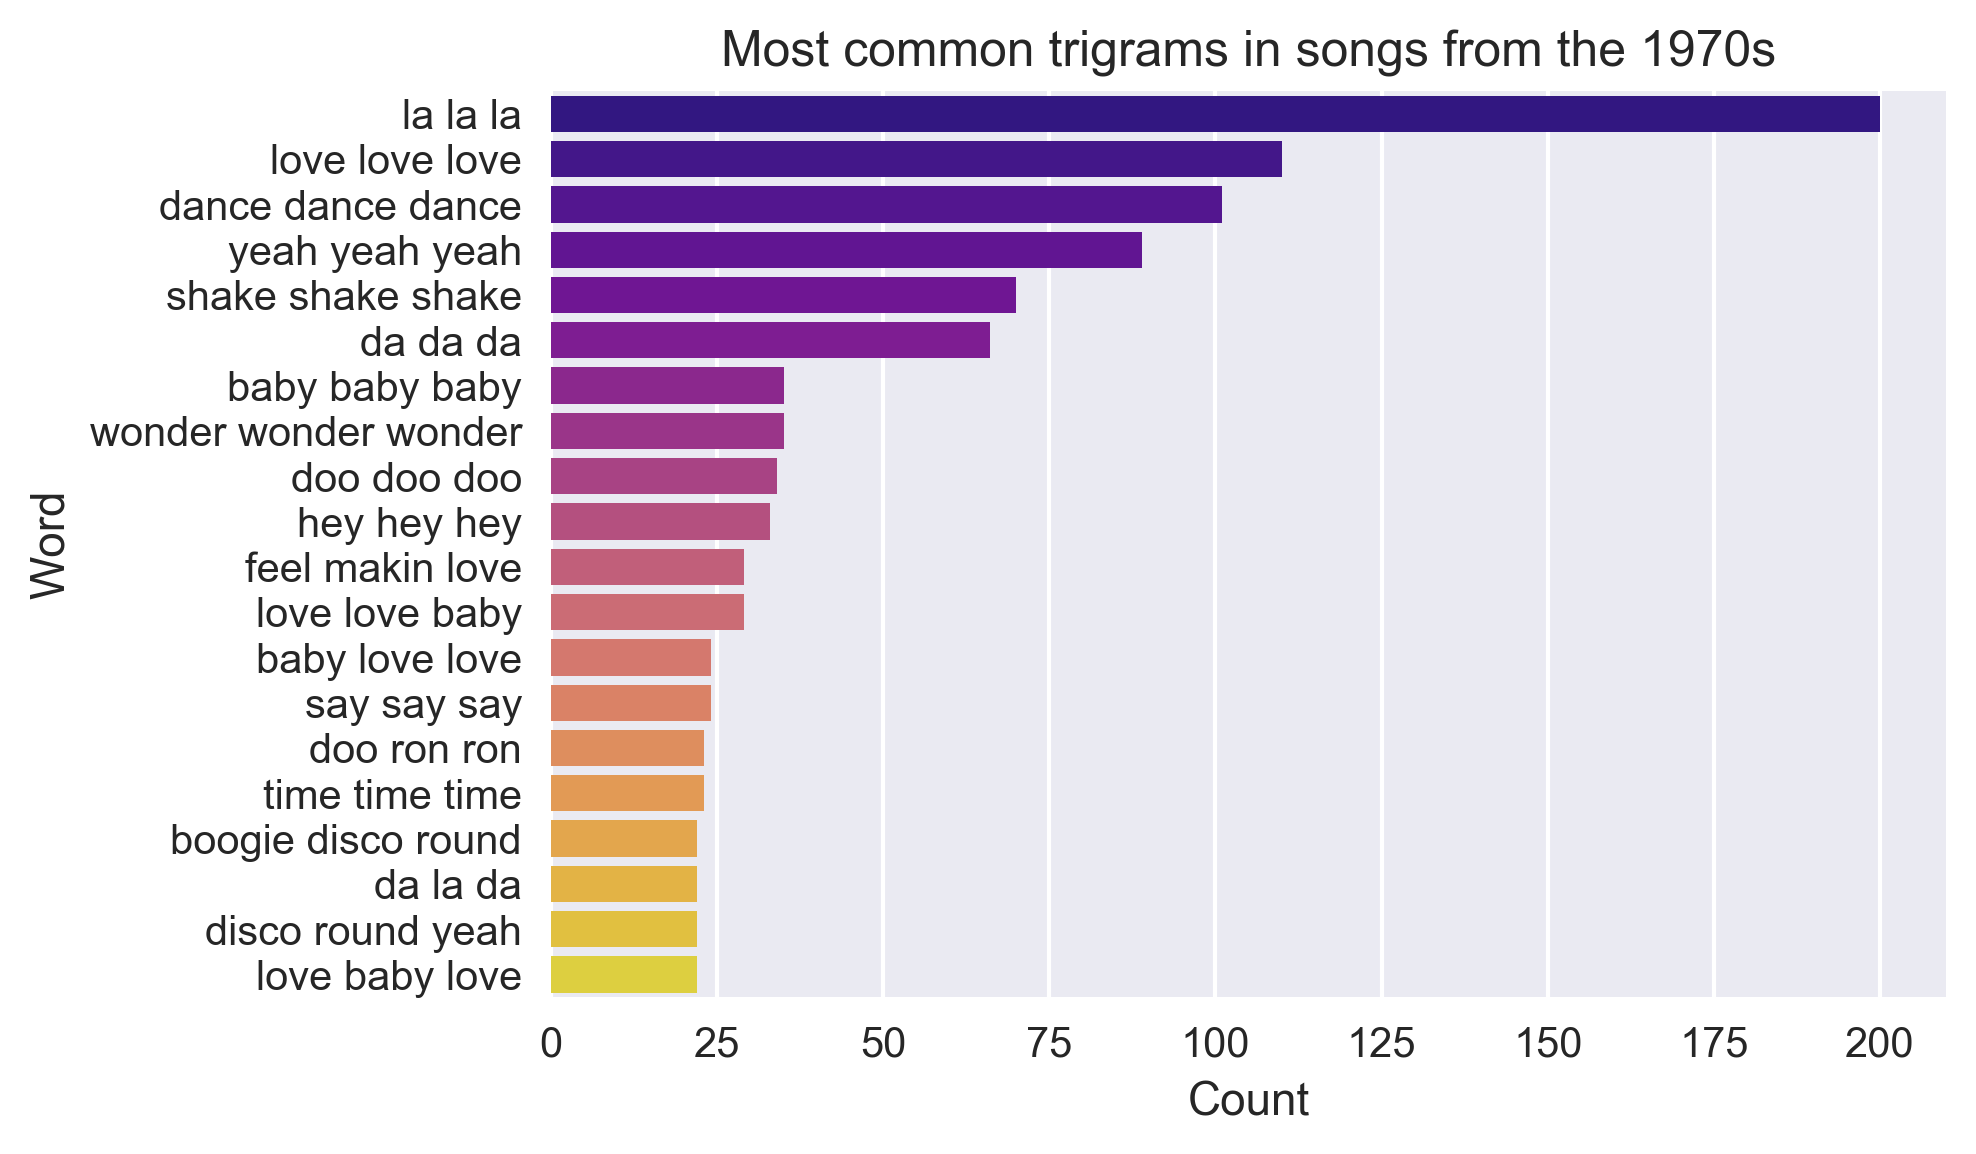

In [10]:
count_vec2_3 = CountVectorizer(max_df=.95, min_df=2, stop_words=stop, ngram_range=(3, 3))
cv2_3 = count_vec2_3.fit_transform(decade2lyrics)
cv_fn2_3 = count_vec2_3.get_feature_names()

words2_3, count2_3 = top_20_words(cv2_3, cv_fn2_3)
plot_top_20(words2_3, count2_3, 'Most common trigrams in songs from the 1970s')

Similar to the previous decade, the words 'love' and 'baby' are the top two common words in the 70s. We see the words ranked 10-20 are a lot different than the top 10-20 words from 1965 to 1969. The words 'dance', 'home', and 'life' make the top 20 and the word 'girl' isn't in the top 5 anymore. 

----

## 1980-1989<a id='80s'></a>

In [11]:
decade3lyrics = lyrics[lyrics['Year'].between(1980, 1989, inclusive=True)]['Lyrics'].values
decade3lyrics = [i for i in decade3lyrics if type(i) == str]

tfidfv3 = TfidfVectorizer(max_df=.955, min_df=1, stop_words=stop)
tv3 = tfidfv3.fit_transform(decade3lyrics)
tv3_fn = tfidfv3.get_feature_names()

decade3NMF = NMF(n_components=6, random_state=1).fit(tv3)

show_sk_topics(decade3NMF, tv3_fn, 11)

Topic 0:
love hold feel life true bring somebody need tell day heart

Topic 1:
na la eh hurt respect change knowwhat yeah uh maybe man

Topic 2:
time say heart need tell away feel life mind eyes look

Topic 3:
baby yeah girl right stand honey time sweet bad need little

Topic 4:
tonight hold right light everybody heartache tight ooooh celebrate sweet somebodys

Topic 5:
night dance rock yeah feel roll long beat rhythm music heat



The topics from the 1980s are more centered around love compared to the previous decade, but `topic 4` seems to indicate that rock-style music came back into popularity and the disco music of the 70s probably fell out of style.

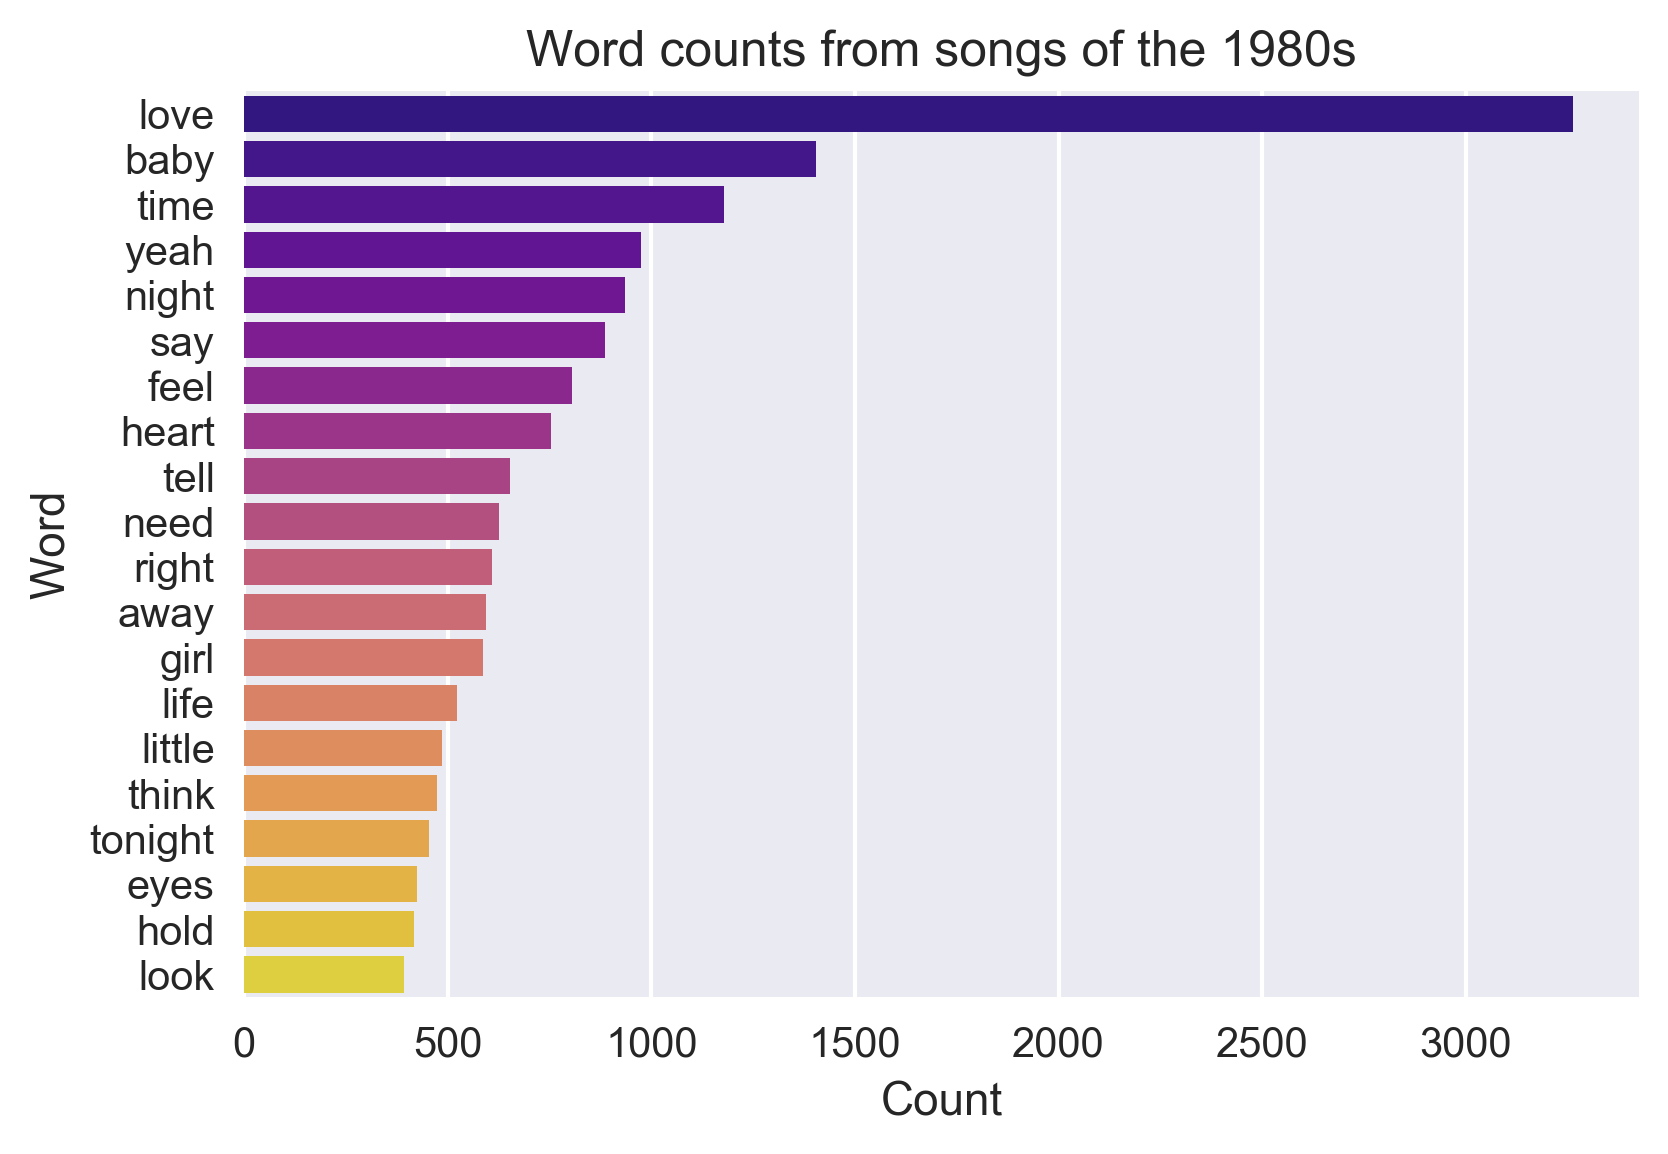

In [12]:
count_vec3 = CountVectorizer(max_df=.95, min_df=2, stop_words=stop)
cv3 = count_vec3.fit_transform(decade3lyrics)
cv_fn3 = count_vec3.get_feature_names()
#decade3LDA = LatentDirichletAllocation(n_components=4, batch_size=6, learning_decay=.65, max_iter=50, learning_method='online').fit(cv3)

words3, count3 = top_20_words(cv3, cv_fn3)
plot_top_20(words3, count3, 'Word counts from songs of the 1980s')

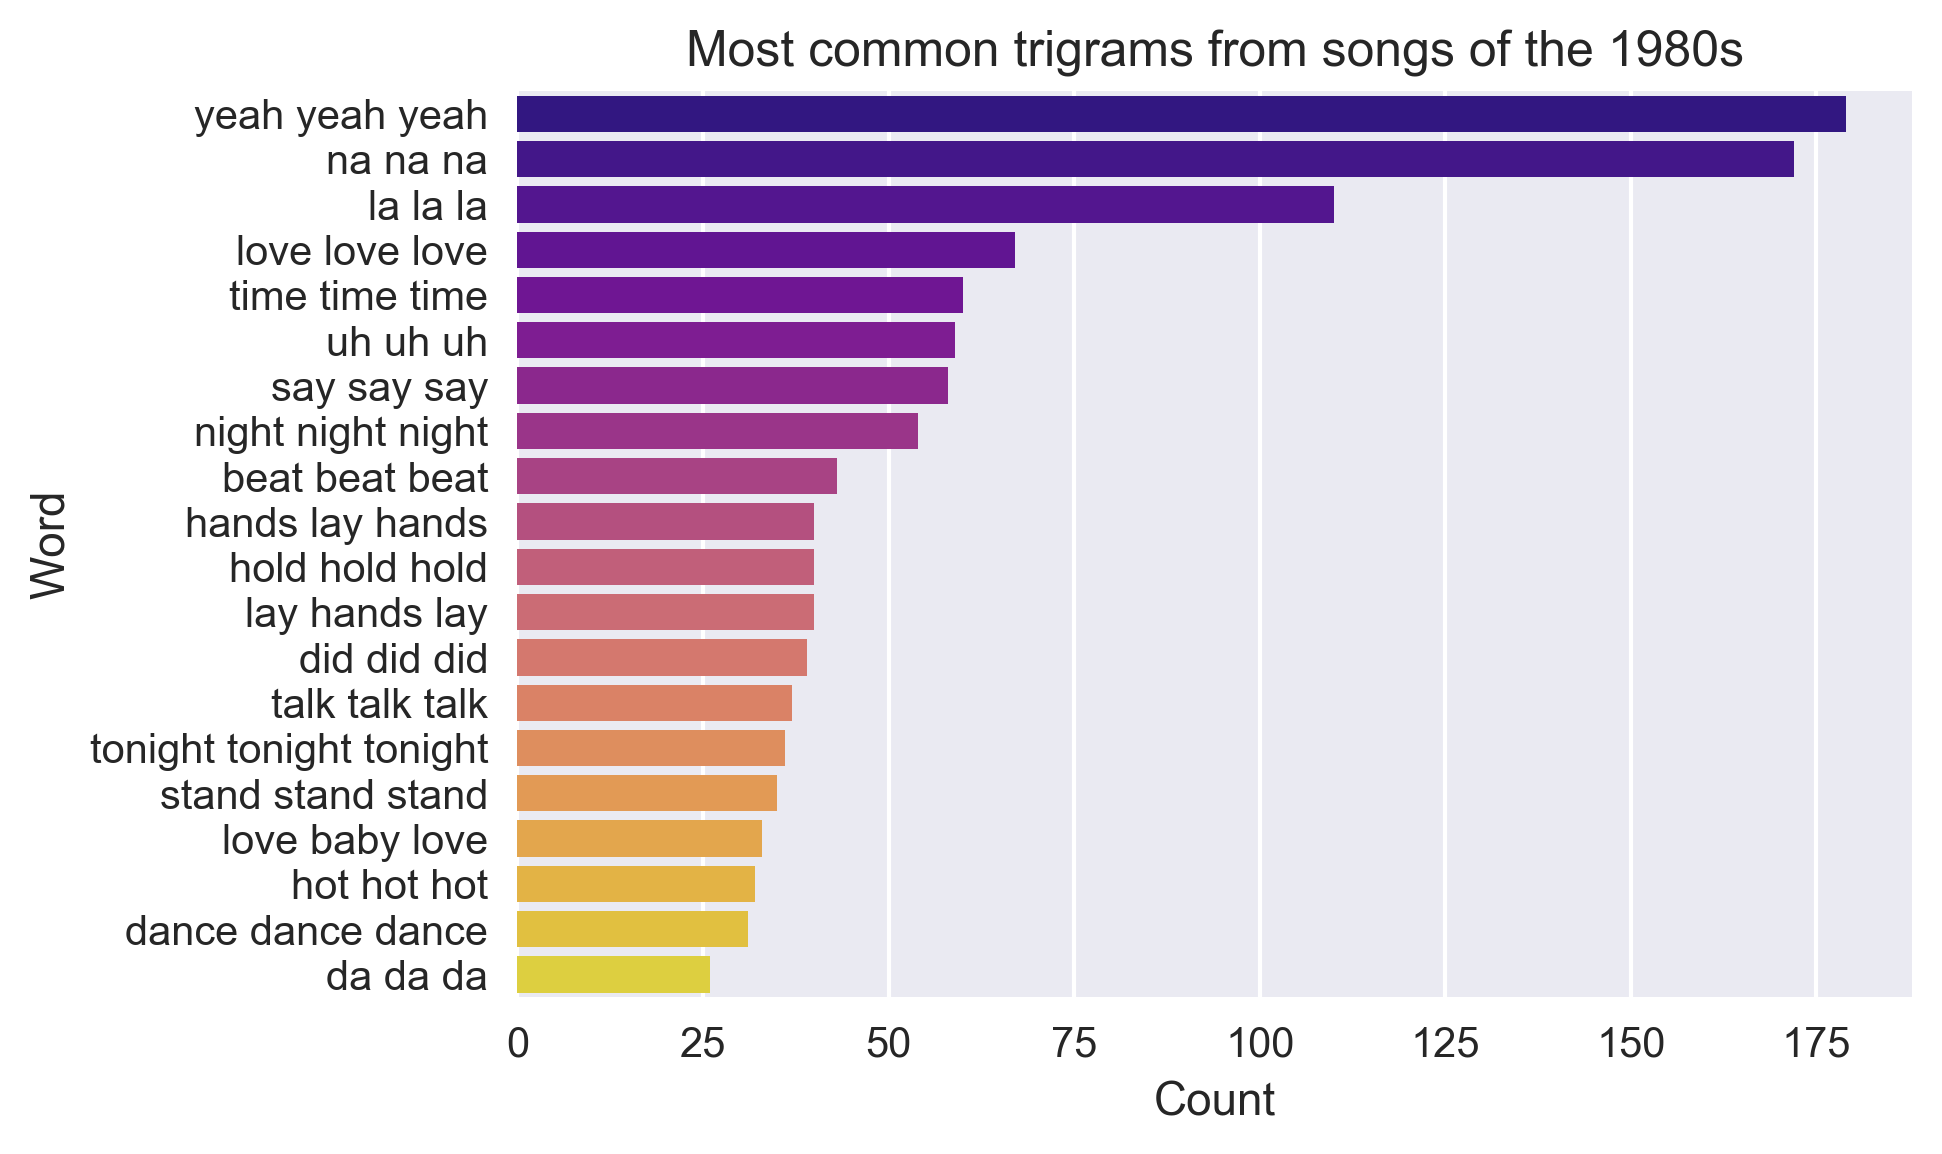

In [13]:
count_vec3_3 = CountVectorizer(max_df=.95, min_df=2, stop_words=stop, ngram_range=(3, 3))
cv3_3 = count_vec3_3.fit_transform(decade3lyrics)
cv_fn3_3 = count_vec3_3.get_feature_names()

words3_3, count3_3 = top_20_words(cv3_3, cv_fn3_3)
plot_top_20(words3_3, count3_3, 'Most common trigrams from songs of the 1980s')

The words 'love,' 'baby,' and 'time,' continue to be the top three most common words used in these Billboard Top 100 songs. Also, 'love' has the highest count to date, which seemed to be reflected in the topic model. The words 'tonight' and 'night' are used a lot more often in this decade which, along with looking at the topics, might suggest a period of time when going out to clubs was more popular. The trigrams do not explain much about the songs of the decade, other than the fact that songs might have become more repetitive in this decade.

----

## 1990-1999<a id='90s'></a>

In [14]:
decade4lyrics = lyrics[lyrics['Year'].between(1990, 1999, inclusive=True)]['Lyrics'].values
decade4lyrics = [i for i in decade4lyrics if type(i) == str]

tfidfv4 = TfidfVectorizer(max_df=0.95, min_df=1, stop_words=stop)
tv4 = tfidfv4.fit_transform(decade4lyrics)
tv4_fn = tfidfv4.get_feature_names()

decade4NMF = NMF(n_components=7, random_state=1, init='nndsvd').fit(tv4)
show_sk_topics(decade4NMF, tv4_fn, 12)

Topic 0:
love girl night heart need forever believe real true dream hold hurt

Topic 1:
na murderer nah rush di uhh nana lovely stepper lyrical hm gangster

Topic 2:
heart time away feel say life tell world hold day said need

Topic 3:
baby need girl gotta tonight babe wants body tell right night boy

Topic 4:
yeah time crazy ah hey doing dance everybody saying feel azz repeat

Topic 5:
ya man little girl gotta shit play really real ride yo yall

Topic 6:
da di la set lovely duh everybody doom words dance dee adrift



In the 90s, topics also cover love, but also profanity makes its first appearance in the topic models. Dance-pop and hip-hop became really successful in this decade [(source)](https://en.wikipedia.org/wiki/1990s_in_music), which might explain a shift in topics.

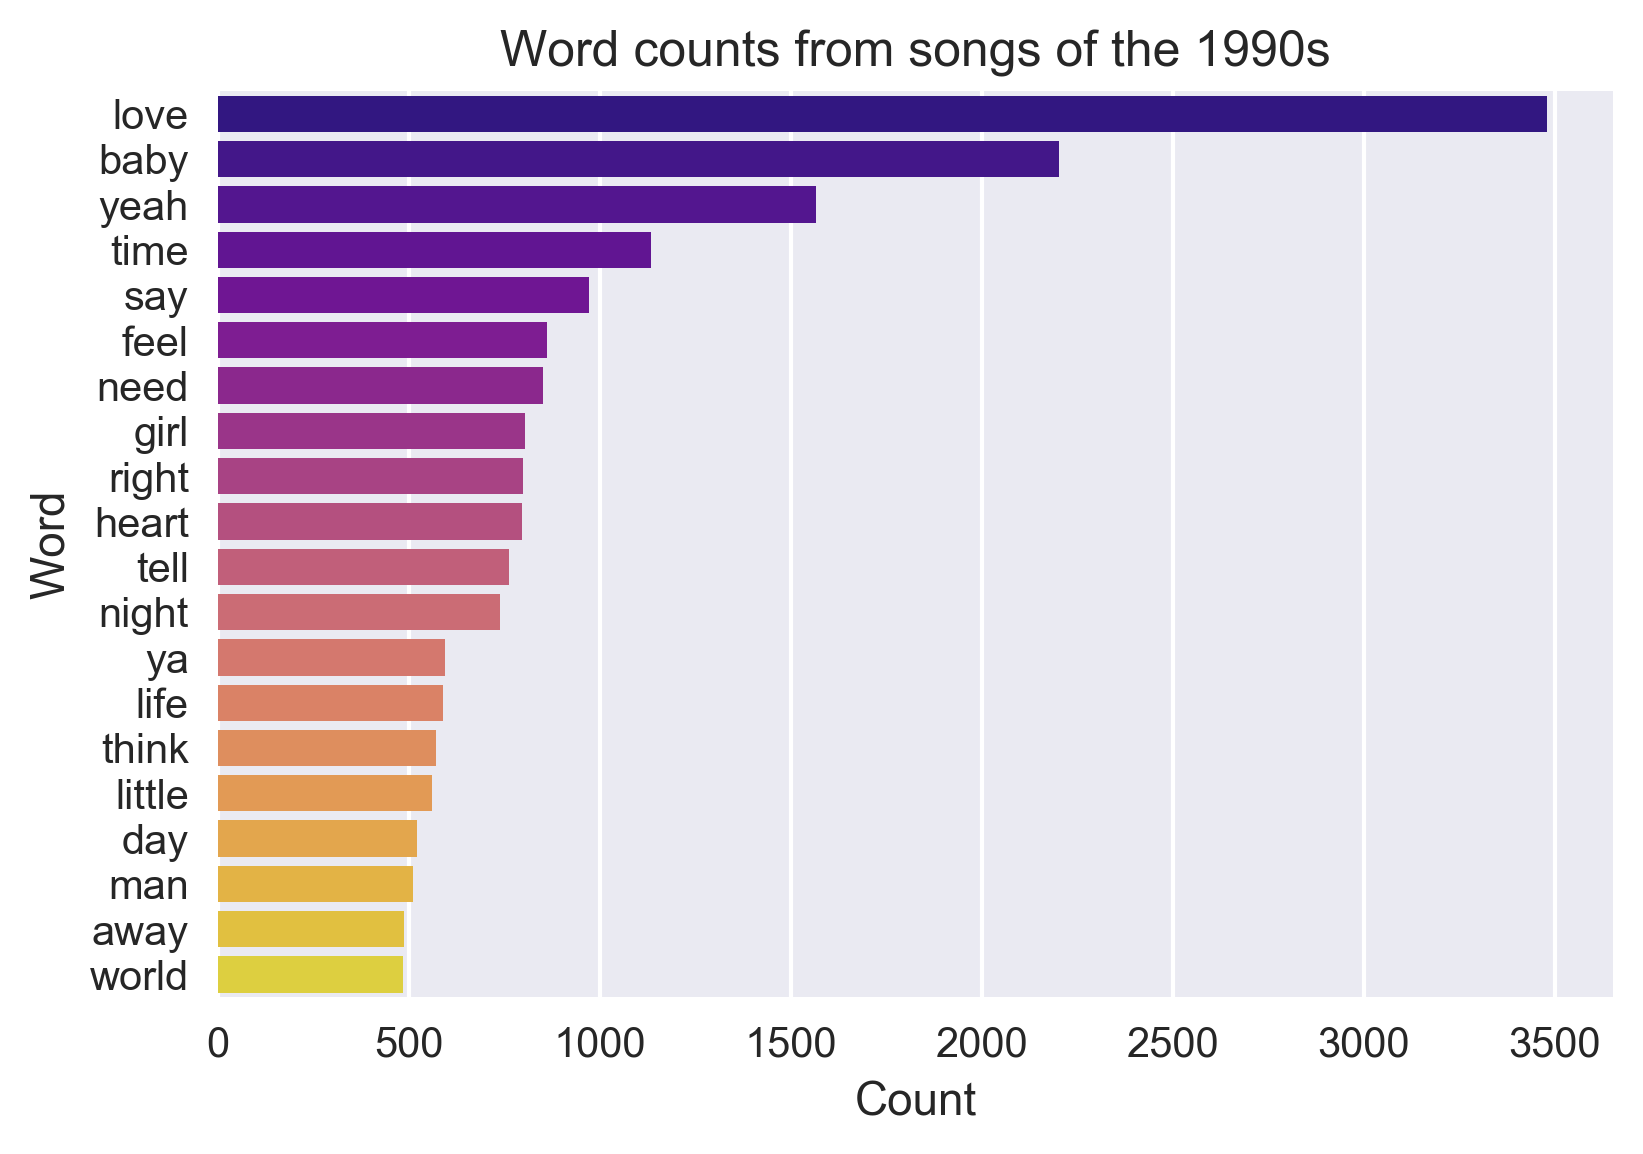

In [15]:
count_vec4 = CountVectorizer(max_df=.95, min_df=2, stop_words=stop)
cv4 = count_vec3.fit_transform(decade4lyrics)
cv_fn4 = count_vec3.get_feature_names()
#decade4LDA = LatentDirichletAllocation(n_components=6, batch_size=45, learning_decay=.7, max_iter=30, learning_method='online').fit(cv4)

words4, count4 = top_20_words(cv4, cv_fn4)
plot_top_20(words4, count4, 'Word counts from songs of the 1990s')

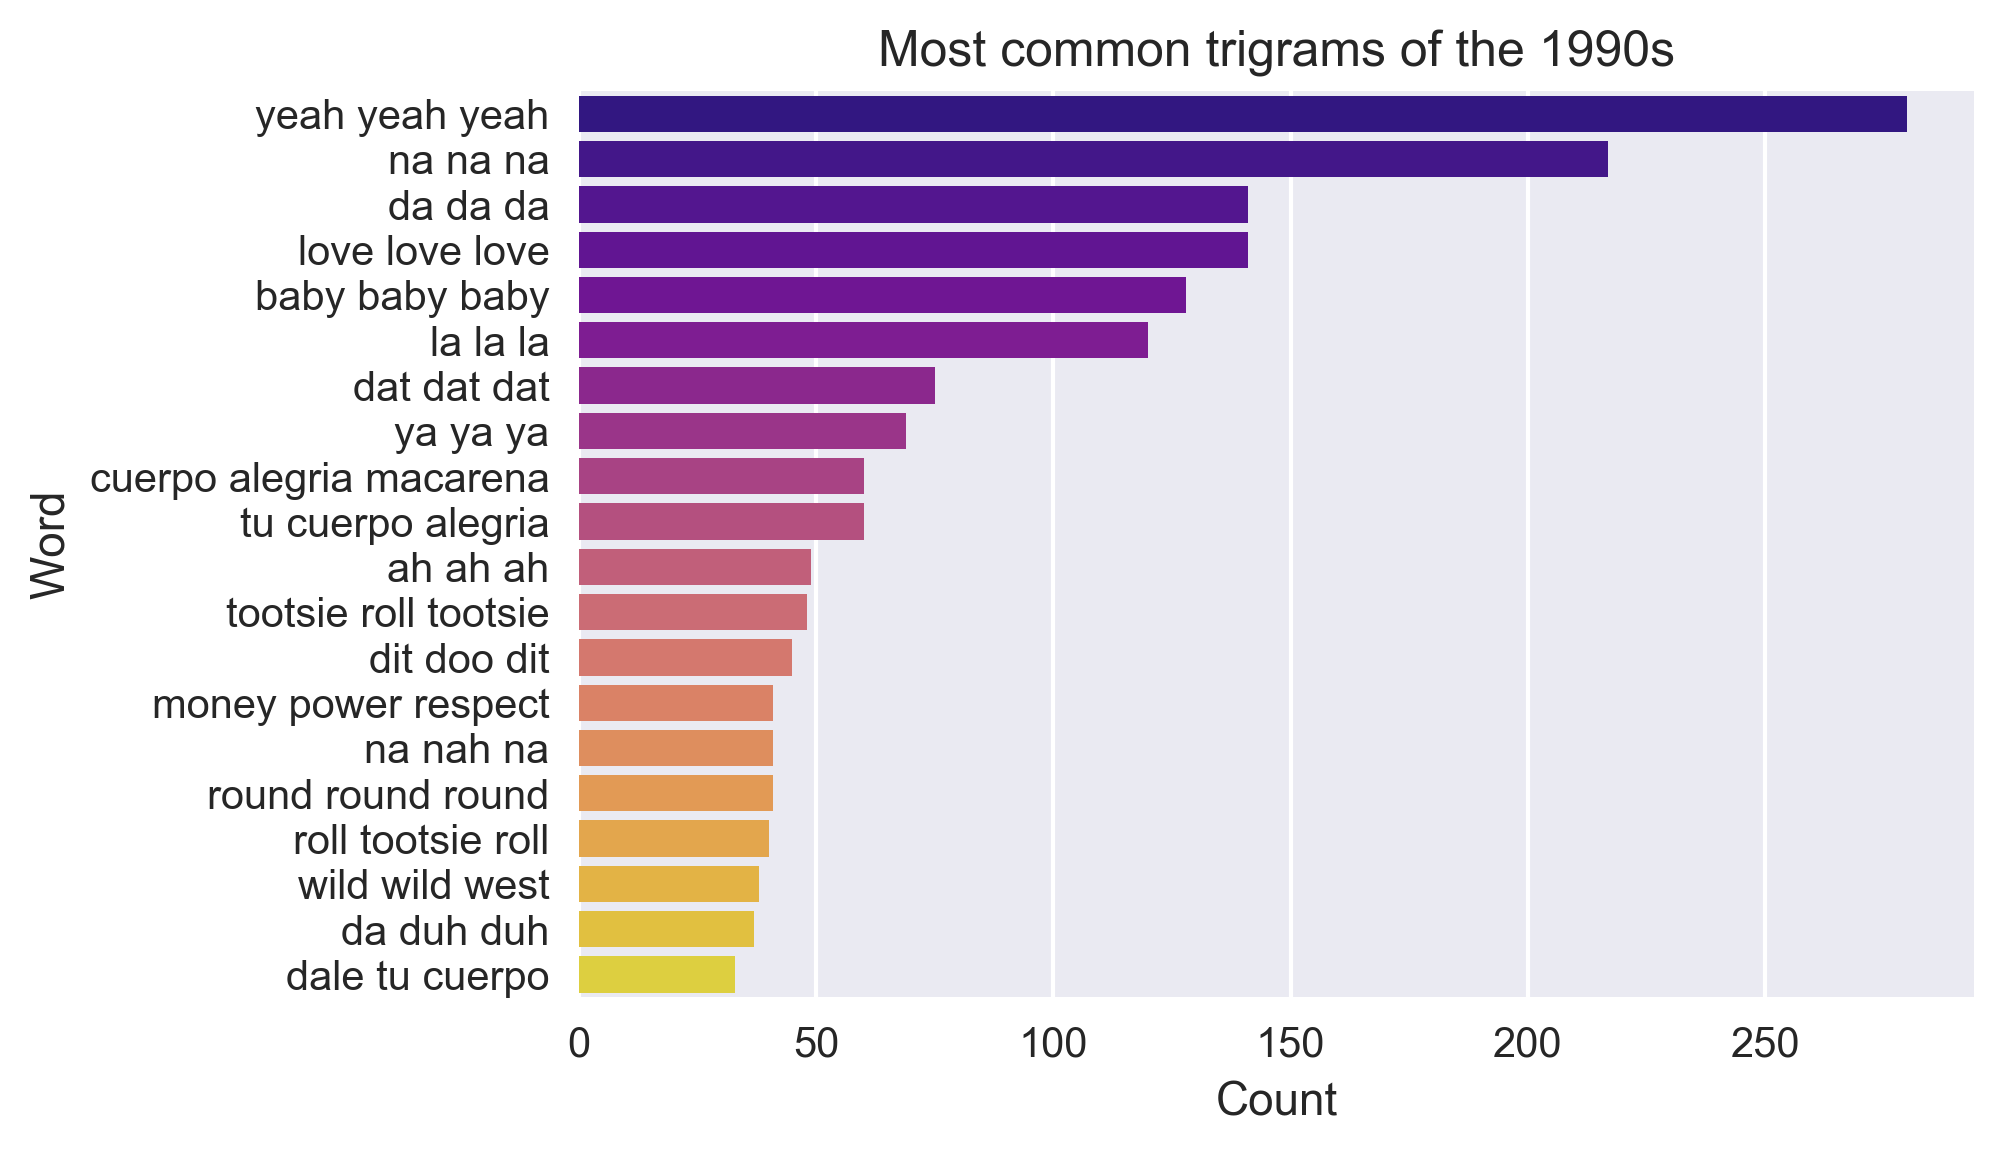

In [16]:
count_vec4_3 = CountVectorizer(max_df=.85, min_df=1, stop_words=stop, ngram_range=(3, 3))
cv4_3 = count_vec4_3.fit_transform(decade4lyrics)
cv_fn4_3 = count_vec4_3.get_feature_names()

words4_3, count4_3 = top_20_words(cv4_3, cv_fn4_3)
plot_top_20(words4_3, count4_3, 'Most common trigrams of the 1990s')

The words 'love' and 'baby' continue to hold the top two spots in the most common words of each decade. The count for the word 'girl' is the highest in two decades and the word 'world' makes an appearance in the top 20 for the first time since the 1960s. 

The trigrams are very interesting as well, as they are much more varied and revealing of the songs in this decade. Some common trigrams are composed of words that make sounds than actual interpretable phrases, which suggests a shift in style in which popular songs use meaningless words. The trigram 'cuerpo alegria macarena' comes from the song "La Macarena" by Los Del Rio and the trigrams about tootsie roll comes from the song "Tootsee Roll" by 69 Boyz. The fact that trigrams unique to certain songs are showing up on this chart might suggest that songs are becoming more repetitive.

----
## 2000-2010<a id='00s'></a>

In [17]:
decade5lyrics = lyrics[lyrics['Year'].between(2000, 2009, inclusive=True)]['Lyrics'].values
decade5lyrics = [i for i in decade5lyrics if type(i) == str]

tfidfv5 = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=stop)
tv5 = tfidfv5.fit_transform(decade5lyrics)
tv5_fn = tfidfv5.get_feature_names()

decade5NMF = NMF(n_components=7, random_state=1).fit(tv5)

show_sk_topics(decade5NMF, tv5_fn, 15)

Topic 0:
baby girl need boy lonely time tell think feel spend love tonight say touch gotta

Topic 1:
na rock hey que funny moves right star ha work singin diva tool melody da

Topic 2:
ya uh wit hey girl shit nigga yo hot em club ass shake man right

Topic 3:
time say life away day right feel think heart said gone night need live tell

Topic 4:
love heart dance babe away world step feel whoa lockdown woh man girl clap help

Topic 5:
la hey da mama turn boys losing que ah hates ohh better milkshake switch seek

Topic 6:
yeah said independent boss gone miss thing whoa stand alright happy really backs body did



A lot of the words that contribute to topics in this decade, like the last one, are profanity and shed light on certain popular genres of the decade, such as teen pop (a popular genre of the 90s). Still, love is a prevailing topic in these top Billboard songs.

This topic model also tells us some songs that were on the top charts. `Topic 5` has the word 'milkshake', which I assume is comes from the song 'Milkshake' by Kelis. Upon further research, this song reached position 41 on the 2004 Billboard Top 100. On a similar note, `Topic 6` is reminiscent of 'Miss Independent' by Ne-yo or Kelly Clarkson (both artists made the Top 100 their respective years).

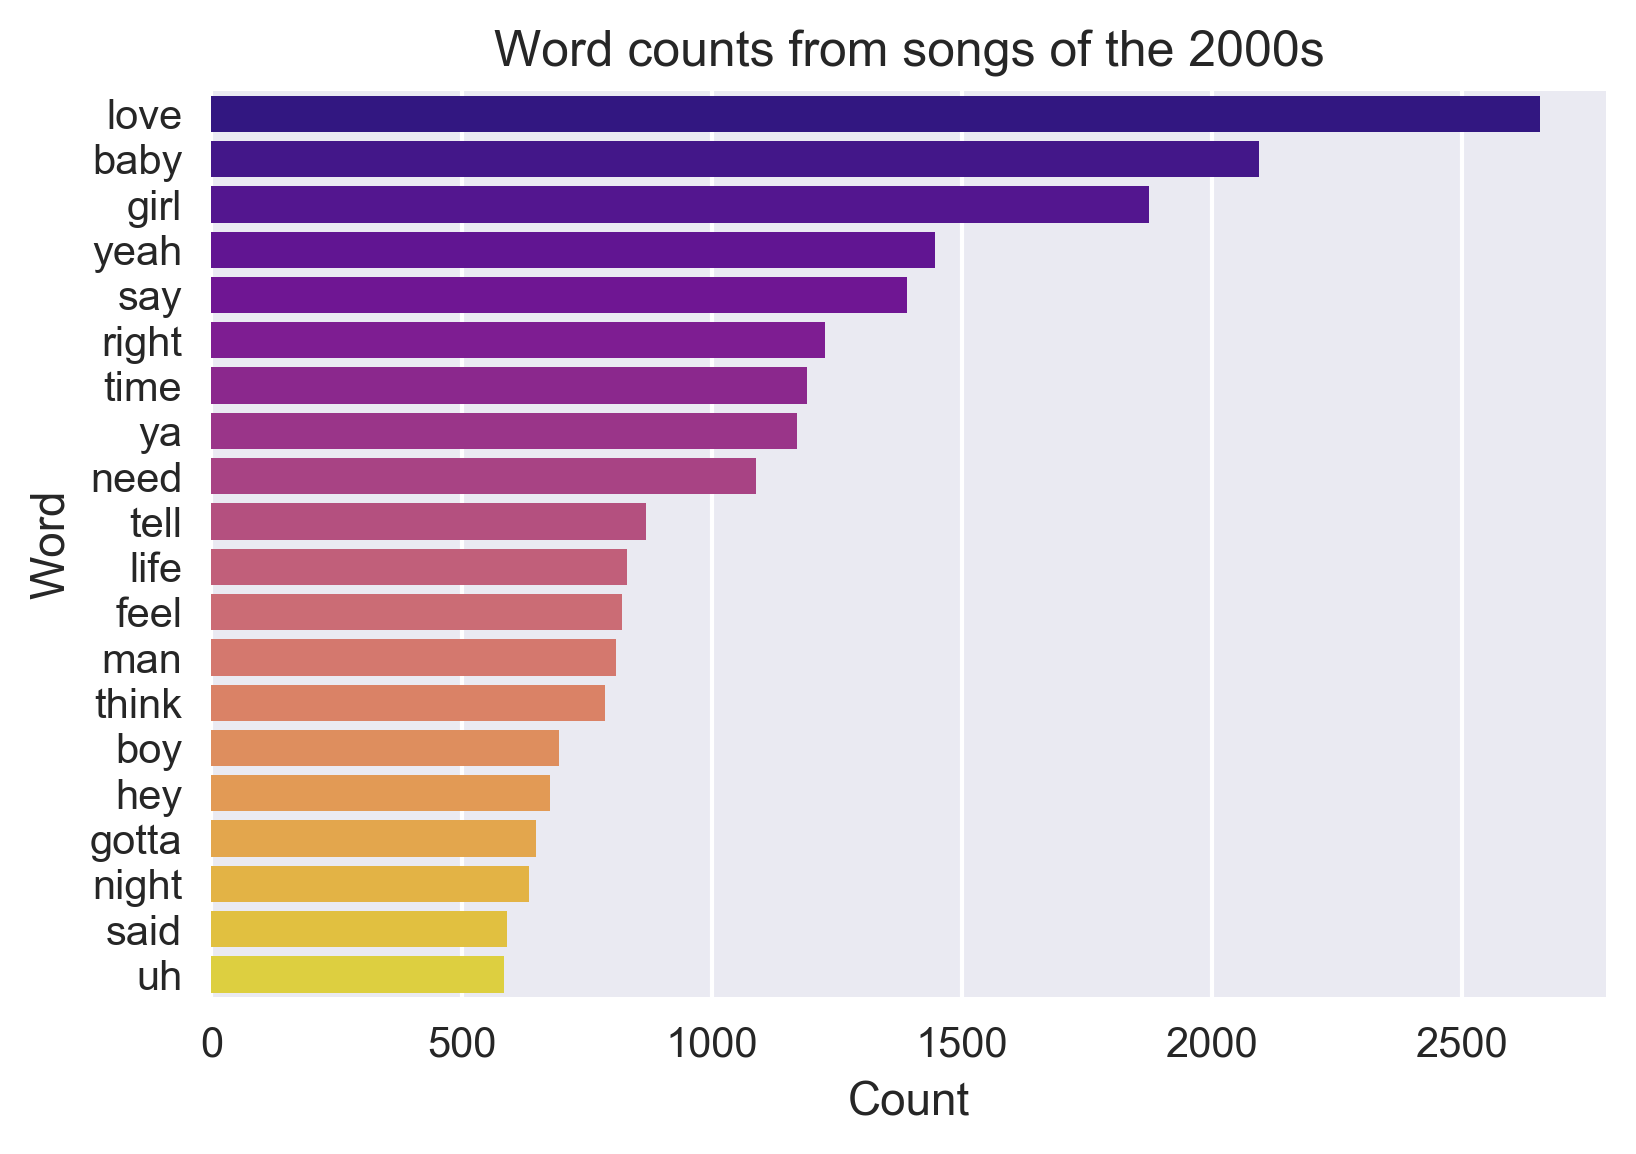

In [18]:
cv = CountVectorizer(max_df=0.95, min_df=2, stop_words=stop)
cv5 = cv.fit_transform(decade5lyrics)
cv_fn5 = cv.get_feature_names()
#decade5LDA = LatentDirichletAllocation(n_components=6, batch_size=40, learning_decay=.7, max_iter=30, learning_method='online').fit(cv5)

words5, count5 = top_20_words(cv5, cv_fn5)
plot_top_20(words5, count5, 'Word counts from songs of the 2000s')

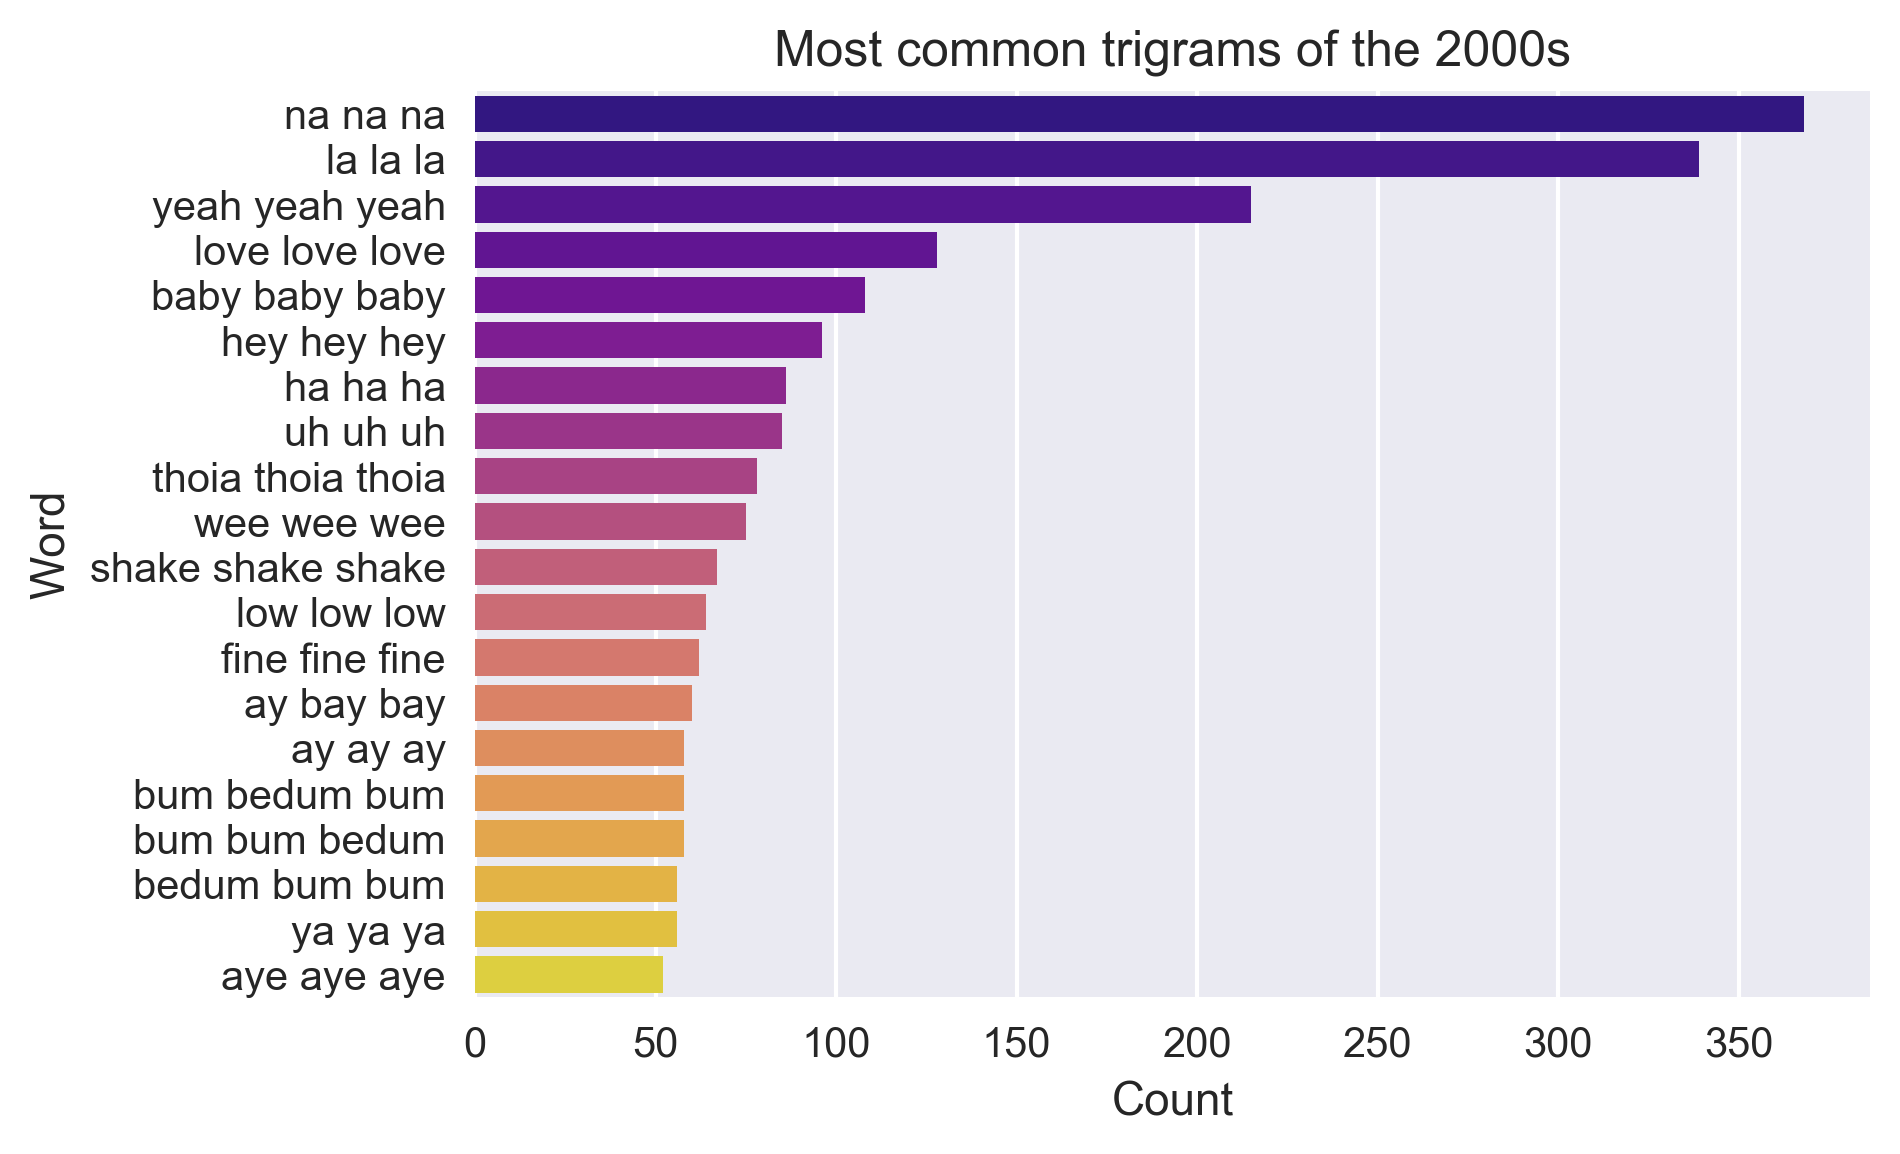

In [19]:
count_vec5_3 = CountVectorizer(max_df=.95, min_df=1, stop_words=stop, ngram_range=(3, 3))
cv5_3 = count_vec5_3.fit_transform(decade5lyrics)
cv_fn5_3 = count_vec5_3.get_feature_names()

words5_3, count5_3 = top_20_words(cv5_3, cv_fn5_3)
plot_top_20(words5_3, count5_3, 'Most common trigrams of the 2000s')

'Girl' is in the top 5 words since the 1960s and both love and baby are still the top two most common words. Another interesting thing is that it is the first time 'boy' shows up in the top 20 words and that this decade has 'gotta', the first instance of a contraction or more colloquial word in the top 20 word counts.

The trigrams of this decade are very revealing of some of the top songs. The trigram "Bum bum bedum" immediately reminds me of Rihanna's "Disturbia", "low low low" is most likely from Flo-rida's "Low" and "Thoia thoia thoia" is from the song "Thoia Thoing" by R. Kelly. Although the trigrams are revealing, they make me think that songs did get more repetitive if many of trigrams from one single song are coming up on this plot just like the last decade.

----
## 2010-2015<a id='recent'></a>

In [20]:
recent_lyrics = lyrics[lyrics['Year'].between(2010, 2015, inclusive=True)]['Lyrics'].values
recent_lyrics = [i for i in recent_lyrics if type(i) == str]

tfidfv5 = TfidfVectorizer(max_df=0.9, min_df=2, stop_words=stop)
tv5 = tfidfv5.fit_transform(recent_lyrics)
tv5_fn = tfidfv5.get_feature_names()

decade5NMF = NMF(n_components=8, random_state=1, init='nndsvd').fit(tv5)
show_sk_topics(decade5NMF, tv5_fn, 15)

Topic 0:
fuck nigga money bitch niggas bitches shit bad em ass real fuckin girl ya gon

Topic 1:
la world sail girl yeah tonight rise feel knows command dancing ride understands thinking high

Topic 2:
love heart girl need feel learn deep long hard beats think hopeless drug face boy

Topic 3:
na ready boy ceiling whats boyfriend undo beautiful girl took melody night ipod hold whips

Topic 4:
baby yeah girl adorn crazy goes gotta night going roll gone time tomorrow lights remind

Topic 5:
hey girl belong better ho remember lovin sister say home daddys wouldnt blastedi blurred work

Topic 6:
yeah night life tonight time need feel hands little stay right turn body party rock

Topic 7:
whoa nights age radioactive break stand tonight new daylight bad hands welcome leave waitin hold



This decade's topics include lots of profanity. Although some words indicate that the topic is still about love, overall, there are significantly a fewer number of love-related words and topics in in this decade. Also, it's the first time in which `Topic 0` isn't related to love. The topics as well as the trigrams (seen two charts below) indicate that there is a proliferation of profanity used in the lyrics of popular songs.

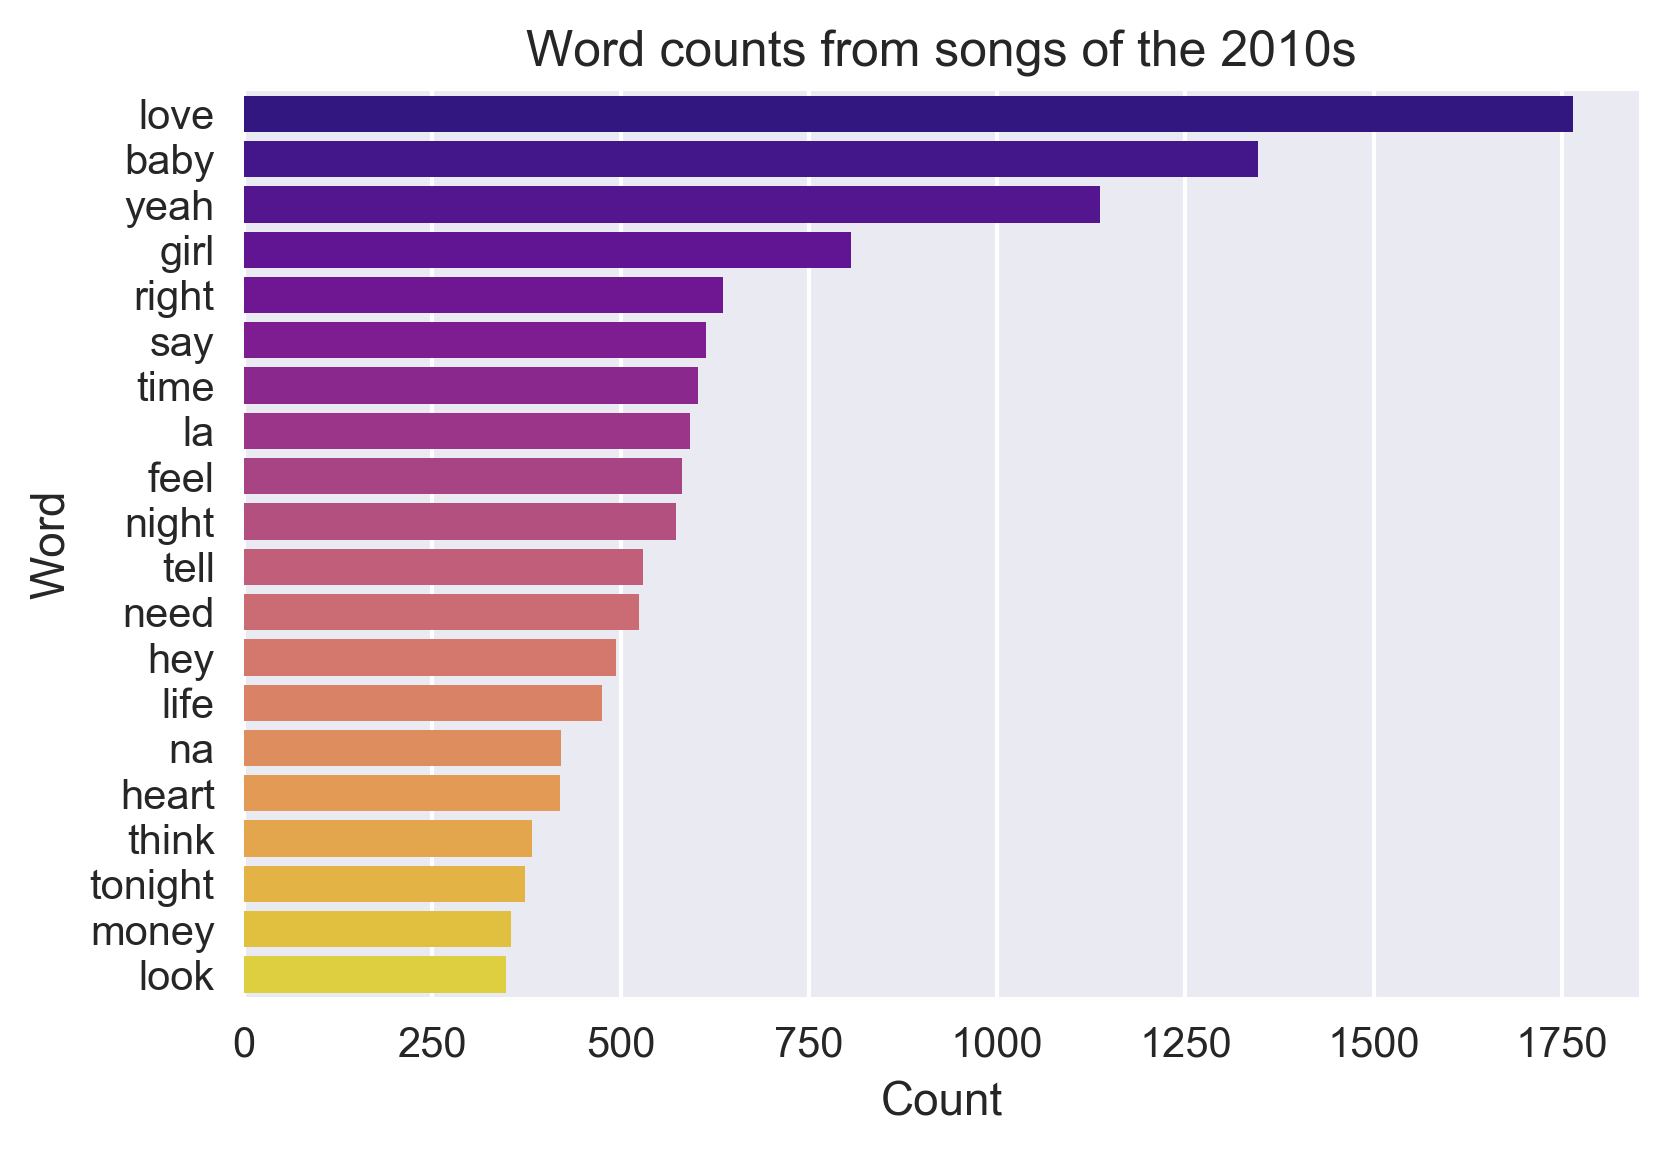

In [21]:
cv = CountVectorizer(max_df=0.95, min_df=2, stop_words=stop)
cv6 = cv.fit_transform(recent_lyrics)
cv_fn6 = cv.get_feature_names()
#recent_LDA = LatentDirichletAllocation(n_components=10, batch_size=75, learning_decay=.7,max_iter=30, learning_method='online').fit(cv6)

words6, count6 = top_20_words(cv6, cv_fn6)
plot_top_20(words6, count6, 'Word counts from songs of the 2010s')


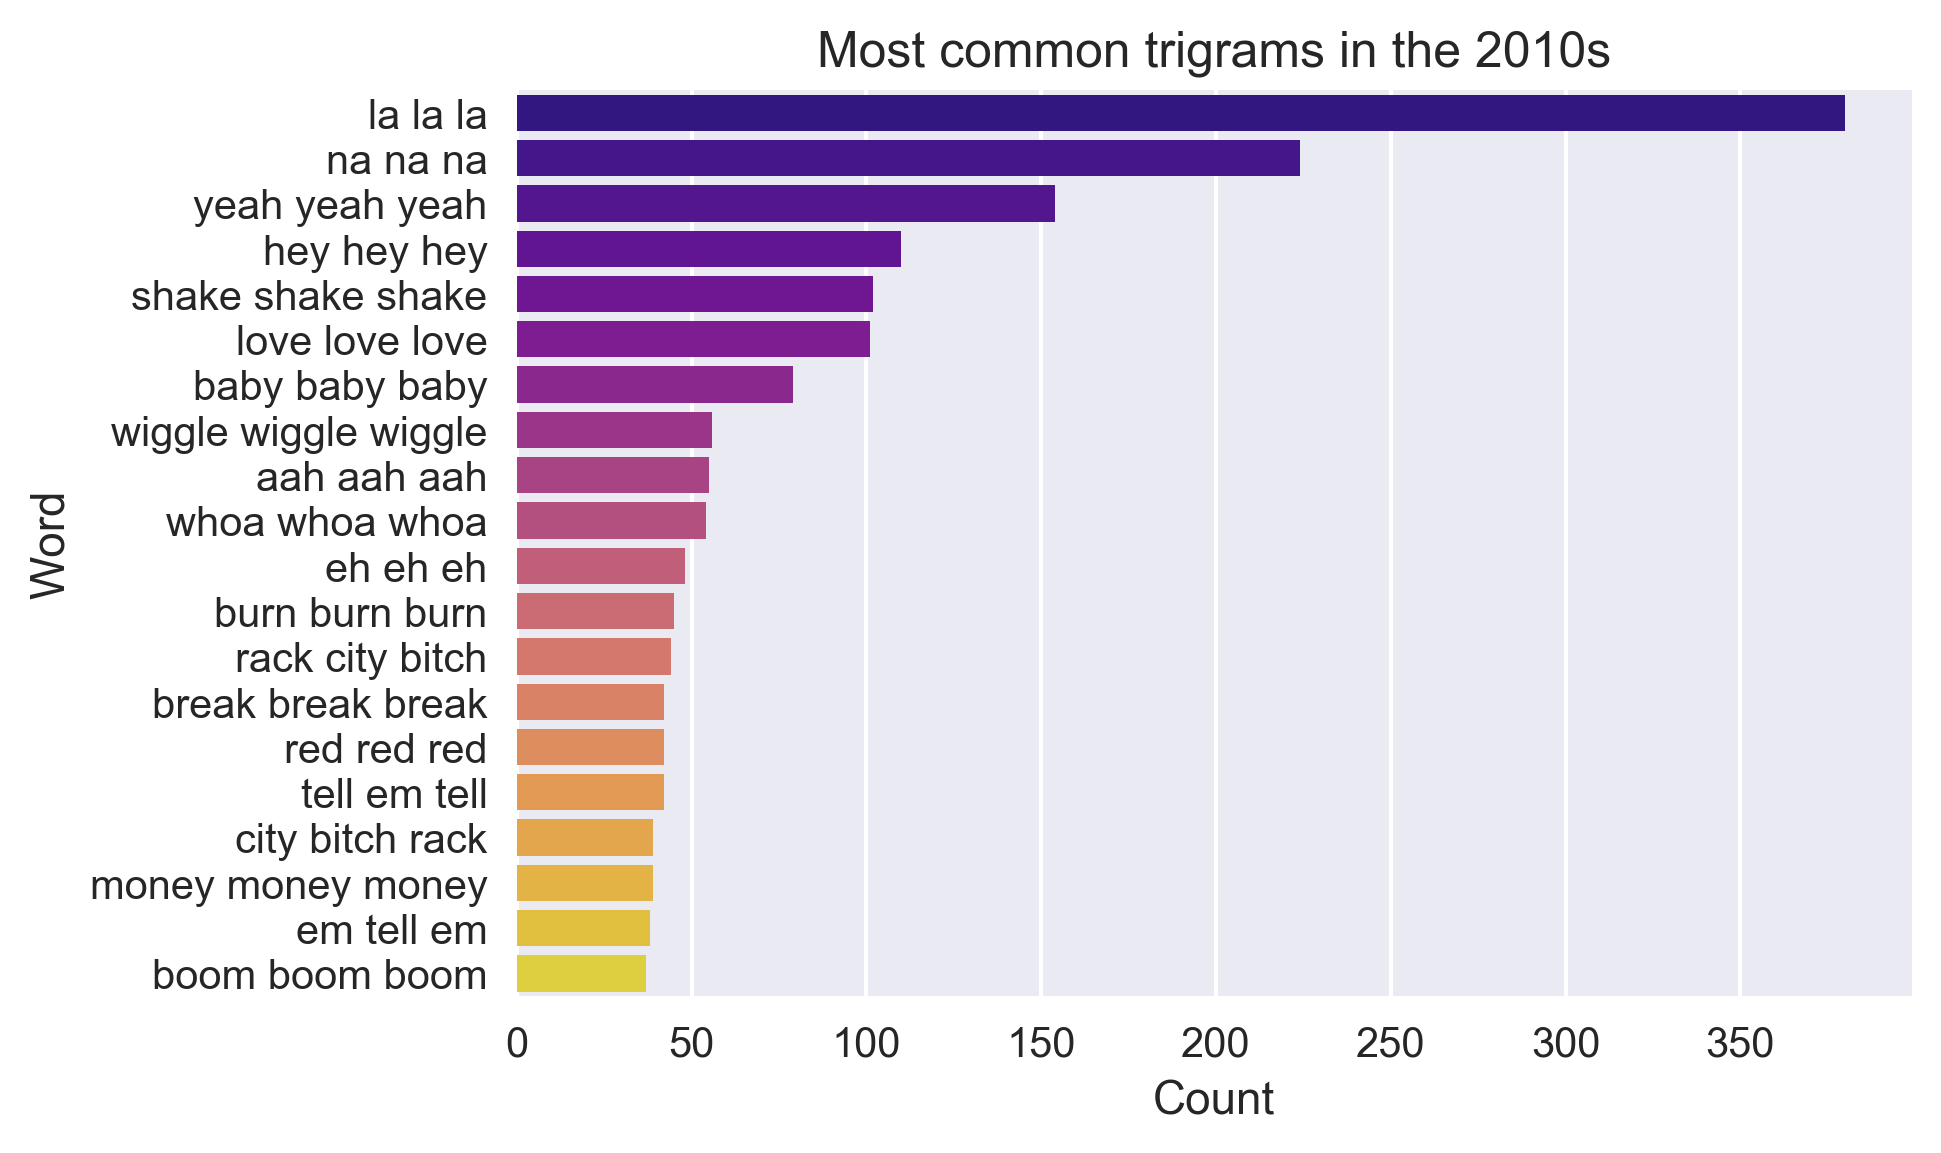

In [22]:
count_vec6_3 = CountVectorizer(max_df=.95, min_df=1, stop_words=stop, ngram_range=(3, 3))
cv6_3 = count_vec6_3.fit_transform(recent_lyrics)
cv_fn6_3 = count_vec6_3.get_feature_names()

words6_3, count6_3 = top_20_words(cv6_3, cv_fn6_3)
plot_top_20(words6_3, count6_3, 'Most common trigrams in the 2010s')

Looking at the word counts, this is the first time the word 'la' is in the top 10 and is it's first appearance on the top 20 since the 1970s. Another interesting thing from the word counts is that this is the first time the word 'money' appears in the top 20 word counts.

The trigrams are also revealing of the songs of this recent five year period. The trigram "la la la" is the most common trigram. Despite the fact that this trigram is present in other decades, this trigram is used almost 400 times in this five year span. Also, many of the trigrams are used in singular songs (e.g. "Rack City" by Tyga) which strongly indicates that, along with this and the previous fact, songs have become repetitive. 


----

## Overall counts from 50 years<a id='overall'></a>

Out of curiosity, I wanted to see the most used songs overall. I wouldn't be surprised to see 'love' and 'baby' at the top of the chart, since those were the two words that topped each chart every decade. 

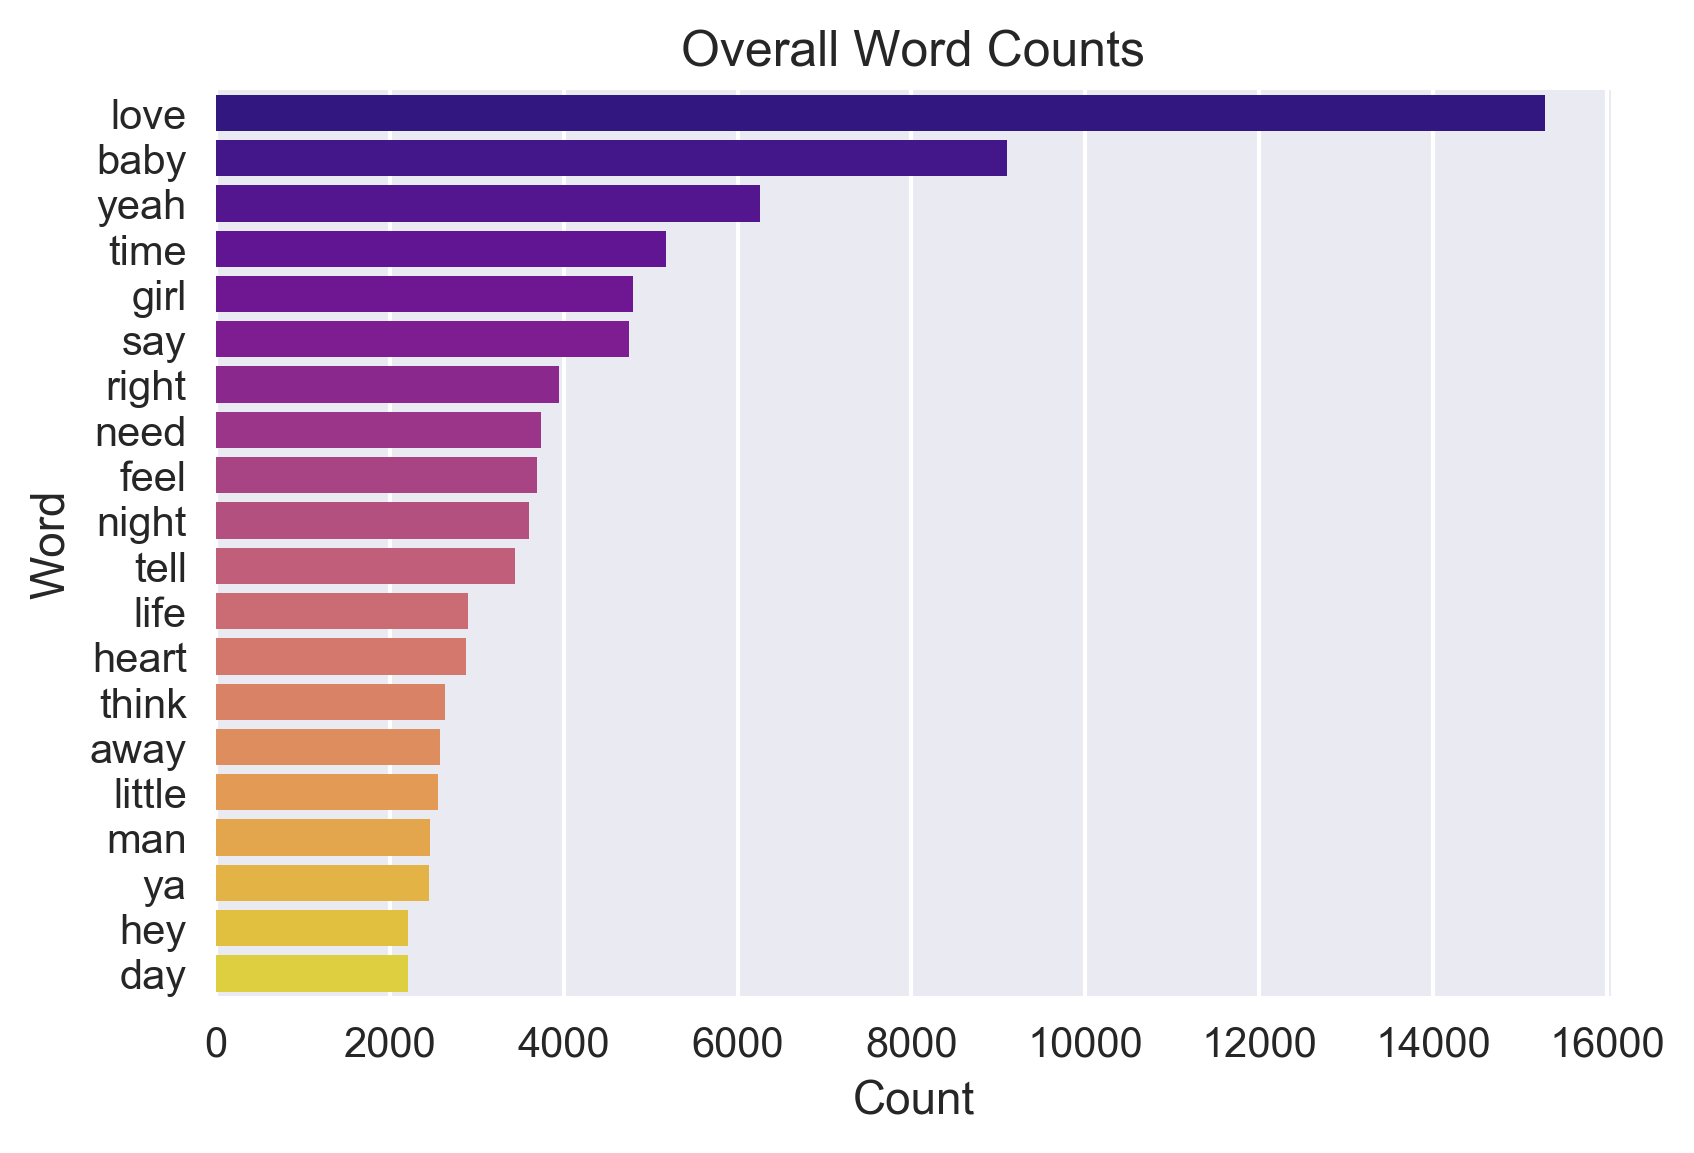

In [23]:
all_lyrics = lyrics['Lyrics'].values
all_lyrics = [i for i in all_lyrics if type(i) == str]

vectorizer = CountVectorizer(max_df=.95, min_df=2, stop_words=stop)
overall_cv = vectorizer.fit_transform(all_lyrics)
overall_fn = vectorizer.get_feature_names()

overall_words, overall_counts = top_20_words(overall_cv, overall_fn)
plot_top_20(overall_words, overall_counts, 'Overall word counts')
plt.title('Overall Word Counts');

Unsurprisingly, 'love' and 'baby' came out on top. For the most part, these words reflect the general nature and content of popular songs, which mostly are about love.

----

# The frequency of different words across each year<a id='section 2'></a>

After going through topic models for each decade and looking at the top words for each decade, I wanted to see if the count of those words were reflected in how often they were used in each song. So I decided to calculate the frequency of certain words every year. I defined the frequency of a certain word in a given year as the average of the number of times the word appeared in a song divided by the total length of a song.

First, I wanted to remove any lyrics that were missing. In this dataset, it was either in the form of an empty string or a `NaN` value.

In [ ]:
removed_null_lyrics = lyrics.loc[lyrics['Lyrics'].notnull()]

#Tokenizing lyrics
tokens = []
for i in removed_null_lyrics['Lyrics']:
    tokens.append([word.lower() for sent in nltk.sent_tokenize(i) for word in nltk.word_tokenize(sent)])
removed_null_lyrics['Tokenized Lyrics'] = tokens

#Further cleaning the data by taking out any lyrics that were empty.
for_indexing =[]
for i in removed_null_lyrics['Tokenized Lyrics'].values:
    if len(i) > 0:
        for_indexing.append(True)
    else:
        for_indexing.append(False)
        
only_w_lyrics = removed_null_lyrics.loc[for_indexing]

I defined these functions to get rid of repetitive code while trying to plot the frequency of words. In `find_freq`, I first create a dictionary which contains the year and the corresponding frequency of the word. I go through each year first, and then through each song and calculate the number of times the word appears in the song and divide it by its length. Once I iterate through all of the lyrics in a year, I'll take the mean of the frequency and then add it to my dictionary.

`freq_to_df` is a function that puts the dictionary from `find_freq` into a `pandas` DataFrame.

In [27]:
def find_freq(word):
    year_freq = {}
    for i in np.arange(1965, 2016):
        freq = np.array([])
        length_song = np.array([])
        lyrics_year = only_w_lyrics[only_w_lyrics['Year'] == i]['Tokenized Lyrics'].values
        for song in lyrics_year:
            freq = np.append(freq, np.count_nonzero(np.asarray(song) == word) / len(song))
        year_freq[i] = np.mean(freq)
    return year_freq

def freq_to_df(dict_of_freq):
    return pd.DataFrame(data={'Year': list(dict_of_freq.keys()), 'Frequency': list(dict_of_freq.values())})[['Year', 'Frequency']]

In the following cell, I decided to plot the words 'baby', 'love', and 'money', because the first two words were the most used words in every decade. I chose the word 'money' because it made the top 20 word counts in 2010-2015.

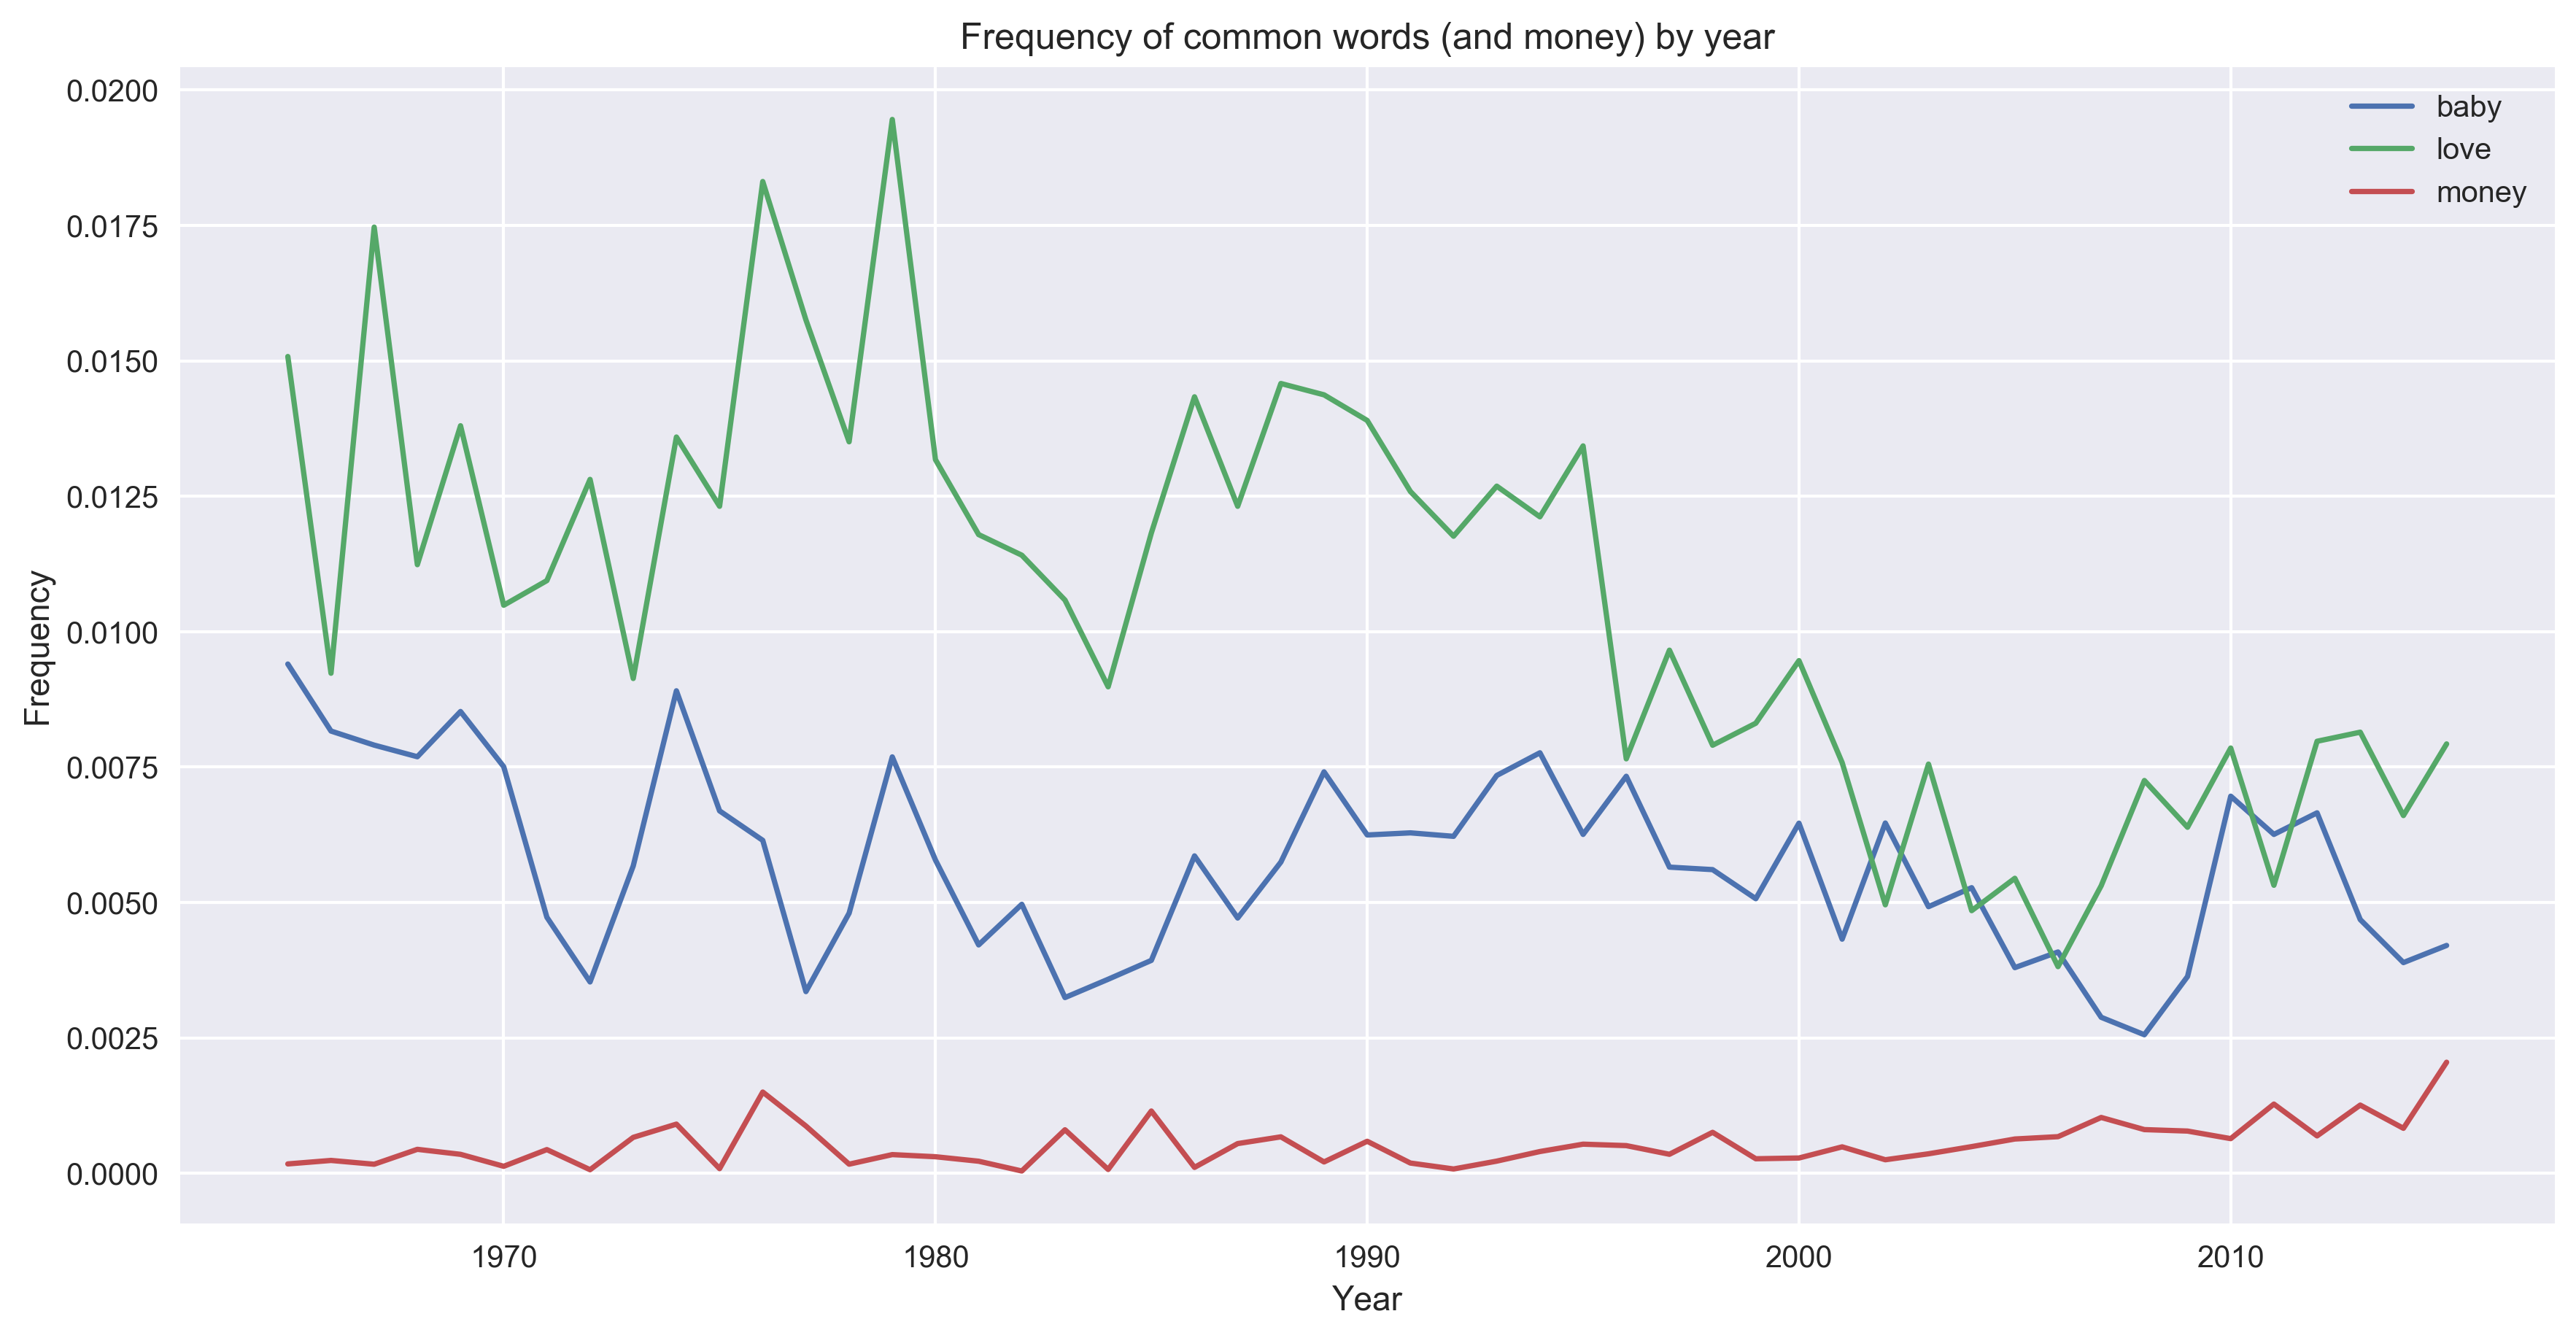

In [28]:
baby_freq = freq_to_df(find_freq('baby'))
love_freq = freq_to_df(find_freq('love'))
money_freq = freq_to_df(find_freq('money'))
plt.figure(dpi=300, figsize=(14, 7));

plt.plot(baby_freq['Year'].values, baby_freq['Frequency'].values)
plt.plot(love_freq['Year'].values, love_freq['Frequency'].values)
plt.plot(money_freq['Year'].values, money_freq['Frequency'].values)

plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title("Frequency of common words (and money) by year")
plt.legend(['baby', 'love', 'money'])
plt.show();

Looks like 'baby' and 'money' aren't being used as often. There is a noticeable drop in the use of 'love' around the the mid-1990s and the use of 'love' hasn't reached the same frequency since then. A possible explanation could be how popular electronic music has gotten in that time, which would not necessarily use words; this trend in EDM continues into the 2000s and even today, there is a prolific amount of electronic music being produced.

I decided to plot the frequency of love for each decade after plotting it by year because I thought the graph doesn't show a good job showing the general trend of frequency of the word.

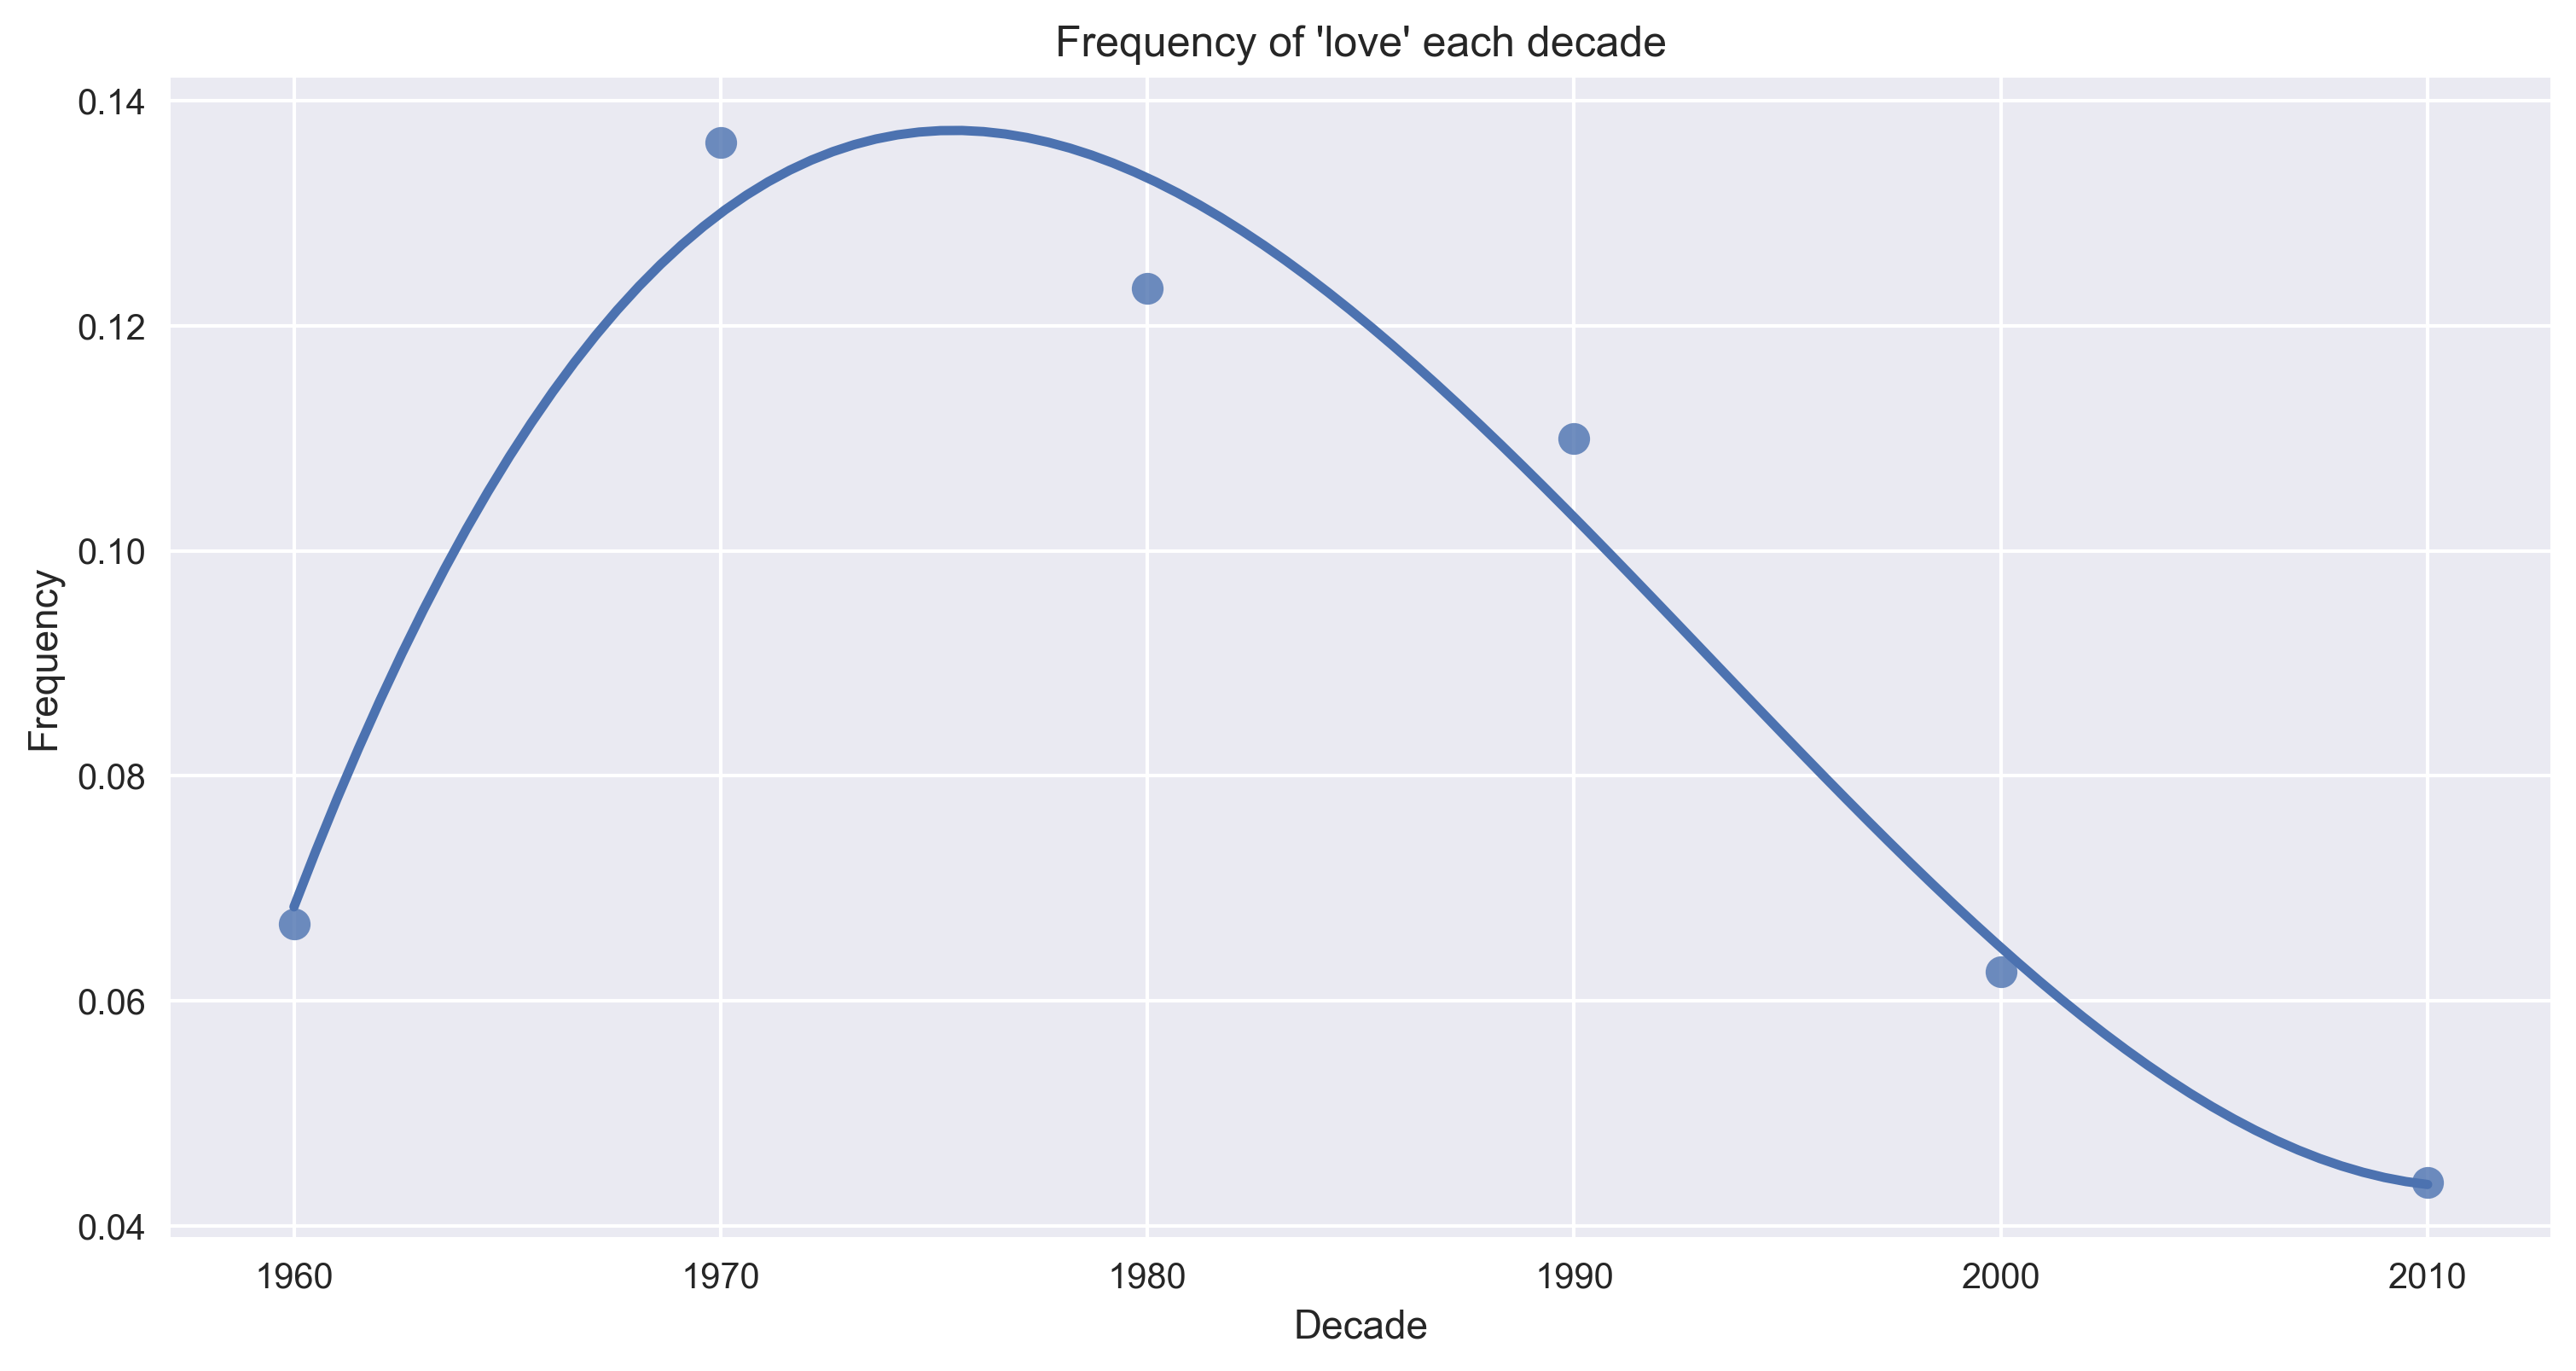

In [29]:
initial = 6
decade_freq = {6:0}
for i in love_freq['Year'].values:
    if i % 100 // 10 != initial:
        initial = i % 100 // 10
        decade_freq[initial] = love_freq[love_freq['Year'] == i]['Frequency'].values[0]
    else:
        decade_freq[initial] = decade_freq[initial] + love_freq[love_freq['Year'] == i]['Frequency'].values[0]

decade = []
freq = []
for k, v in decade_freq.items():
    decade.append(k)
    freq.append(v)
decade = [i * 10 for i in decade]
decade = [i + 1900 for i in decade[:4]] + [i + 2000 for i in decade[4:]]
love_freq_decade = pd.DataFrame(data={'Decade':decade, 'Frequency': freq})

plt.figure(dpi=300, figsize=(12, 6));
plt.title("Frequency of 'love' each decade")
sns.regplot(x='Decade', y='Frequency', data=love_freq_decade,
                scatter_kws={"s": 80},
                order=3, ci=None, truncate=True);

Lastly, I made an interactive function to use so you can see the frequency of a word of your choice.

In [30]:
#This wont show up in the HTML; must be run in ipynb file
def plot_word_freq(word='love'):
    plt.figure(figsize=(14, 6));
    word_freq = freq_to_df(find_freq(word))
    plt.plot(word_freq['Year'].values, word_freq['Frequency'].values)
    plt.xlabel('Year')
    plt.ylabel('Frequency')
    plt.title("Frequency of '" + word + "' in songs by year")
    plt.show();
input_text = widgets.Text(value='love', placeholder='Type a word!', description='Word:', disabled=False)
interactive(plot_word_freq, x=input_text)

A Jupyter Widget

----

# Have songs become more repetitive?<a id='repeat'></a>

My second question when approaching this dataset was, have popular songs become more repetitive? I defined repetitiveness as the proportion of unique tokens in a given song. Using the tokenized lyrics, I calculated the number  of unique tokens by using `np.unique` and divided by the length of the song, and calculated the average for both each decade and each year.

In the following cell, I defined a function `mean_unique` which does what I stated above.

In [31]:
def mean_unique(lower, upper):
    num_unique = np.array([])
    for i in only_w_lyrics[only_w_lyrics['Year'].between(lower, upper - 1, inclusive=True)]['Tokenized Lyrics'].values:
        num_unique = np.append(num_unique, len(np.unique(i))/len(i))
    return np.mean(num_unique)

In [32]:
# Start by making an array with the mean proportion of 1965-1969
decade = np.array([mean_unique(1965, 1970)])
# Do the same for the next decades
for i in np.arange(1970, 2001, 10):
    decade = np.append(decade, mean_unique(i, i+10))
# Code 2010-2015 separately, since intervals of 10 were taken before.
decade_unique = np.append(decade, mean_unique(2010, 2015+1))

# Along with decade, I wanted to see the repetitiveness of songs by year as well.
year_unique = np.array([])
unique_t = np.array([])
for i in np.arange(1965, 2016):
    for i in only_w_lyrics[only_w_lyrics['Year']==i]['Tokenized Lyrics'].values:
        unique_t = np.append(unique_t, len(np.unique(i)) / len(i))
    year_unique = np.append(year_unique, np.mean(unique_t))
    unique_t = np.array([])

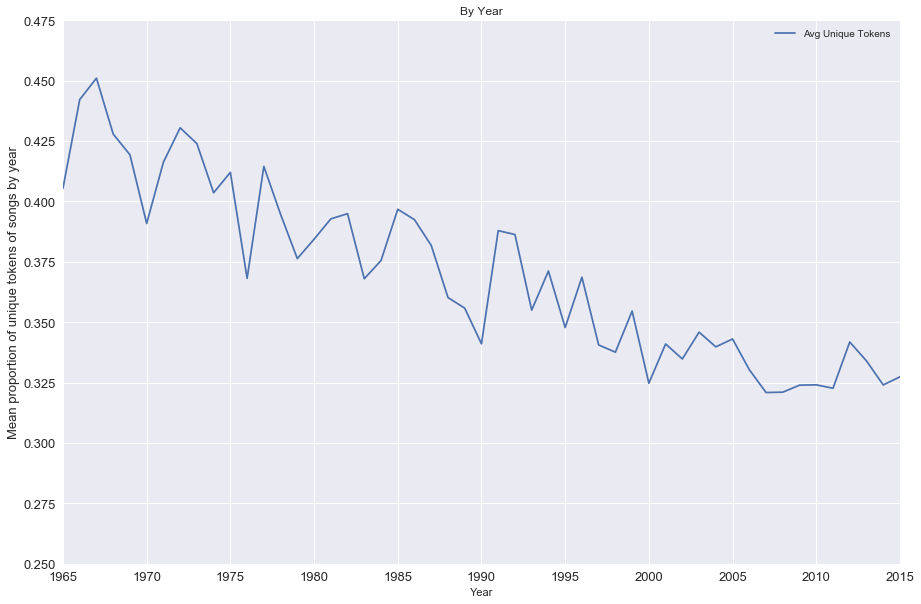

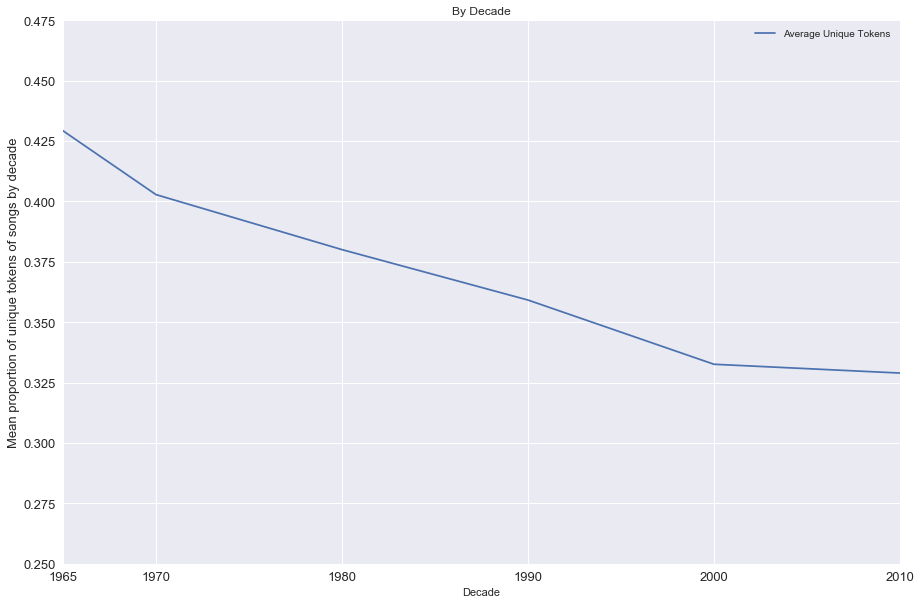

In [33]:
#put all data into dataframe and plot.
df_y_unique = pd.DataFrame(data={'Year':np.arange(1965, 2016), 'Avg Unique Tokens':year_unique})
ax2 = df_y_unique.plot(x='Year', 
                       figsize=(15, 10), 
                       ylim=(0.25, 0.475), 
                       xticks=np.arange(1965, 2016, 5), 
                       fontsize=13)
ax2.set_ylabel('Mean proportion of unique tokens of songs by year', fontsize=13);
ax2.set_title('By Year');
df_d_unique = pd.DataFrame(data={'Decade':np.append(np.array([1965]), np.arange(1970, 2011, 10)), 
                                "Average Unique Tokens": decade_unique})
ax1 = df_d_unique.plot(x='Decade', 
                       figsize=(15, 10), 
                       ylim=(0.25, .475), 
                       xticks=np.append(np.array([1965]), np.arange(1970, 2020, 10)), 
                       fontsize=13)
ax1.set_ylabel('Mean proportion of unique tokens of songs by decade', fontsize=13);
ax1.set_title('By Decade');

With the way I calculated "repetition" in Top 100 songs, songs indeed have become more repetitive over the years. The proportion of the number of unique tokens and the overall number of tokens in a song have decreased and it seems like 2007 was the lowest proportion observed. One thing to take a note of is that songs did get longer over the years.

----
# Who appeared the most on the Top 100?<a id='whomst'></a>

After exploring the lyrics and topics of popular songs, I wanted to see which artist had the most songs on the charts. In the cell below, I plotted a horizontal bar chart that includes the artist and the number of times they appeared on the Billboard Top 100.

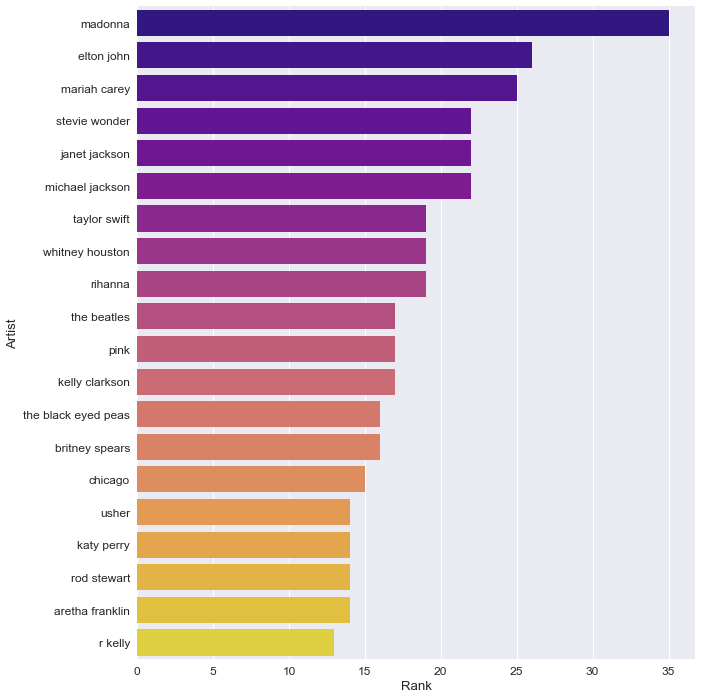

In [44]:
plt.figure(figsize=(10, 12))
sns.set(font_scale=1.2)
artist = lyrics.groupby('Artist').count()
top_20 = artist.sort_values('Rank', ascending=False)[:20]

sns.barplot(y=top_20.index, x=top_20['Rank'], orient='h', order=top_20.index, palette=("plasma"));

Madonna appeared 35 times on the charts over 50 years! How did she get so many songs on the Top 100?

To get an idea, I'll first implement a topic model. First, I'll organize the lyrics by artist. In this case, I'll be selecting where only the artist is 'madonna'. I then will implement a topic model using NMF to see what kind of things she sings about.

In [35]:
madonna = only_w_lyrics[only_w_lyrics['Artist']=='madonna']

vec = TfidfVectorizer(max_df=.95, min_df=2, stop_words=stop)
mv = vec.fit_transform(madonna['Lyrics'].values)
mv_fn = vec.get_feature_names()

madonna_NMF = NMF(n_components=7, init='nndsvd', random_state=1, alpha=.1).fit(mv)
show_sk_topics(madonna_NMF, mv_fn, 15)

Topic 0:
love true baby la say body scared heart waiting deeper feels hey slip right best

Topic 1:
mmm comin somethings babys secret took secretmmm shared understand lies long hand memmm mesomethings learned

Topic 2:
girl world took think day need life time days star wild try truth kept word

Topic 3:
wed baby hearts heart hold lose die watch mind joy point eyes life thought turn

Topic 4:
tell learned live secret man open thousand lies inside till hope stare isnt far rain

Topic 5:
music hey makes flow body mister dance baby starts crazy stop best life goes door

Topic 6:
feel coming home prayer light time loves flying hear waiting gone little remember thunder crazy



Unsurprisingly, the topics cover love, relationships, and possibly dancing and nightlife. Some of her songs can be recognized through these topics, such as "Like a Prayer" in `topic 6` which then can be assumed made the Top 100. 

Next, I'll find the counts of certain words like the first section of this exploration.

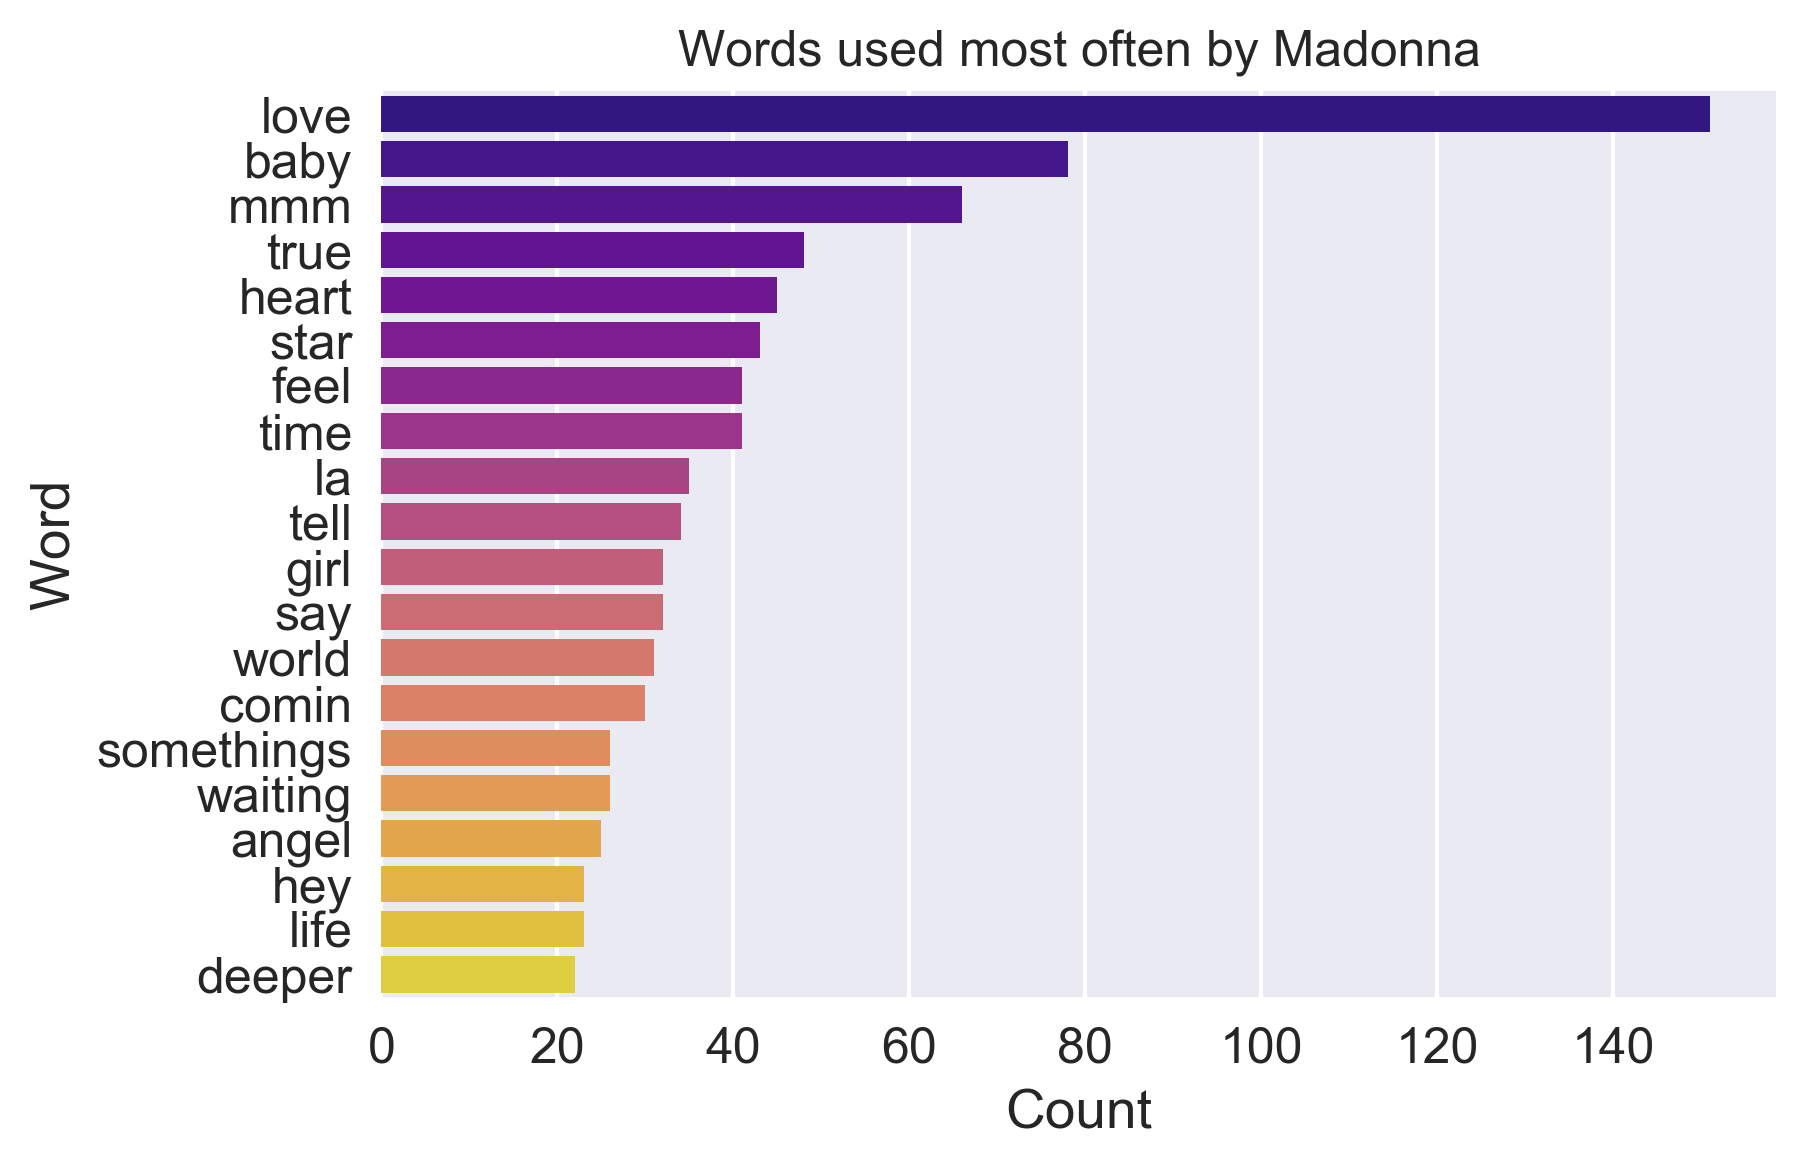

In [36]:
cvec = CountVectorizer(max_df=.95, min_df=2, stop_words=stop)
m_cv = cvec.fit_transform(madonna['Lyrics'].values)
mv_cfn = cvec.get_feature_names()

sorted_words = sorted(list(zip(mv_cfn, np.asarray(m_cv.sum(axis=0)).ravel())), key=lambda x: x[1], reverse=True)
words, count = [i[0] for i in sorted_words[:20]], [i[1] for i in sorted_words[:20]]
plot_top_20(words, count, 'Madonna')
plt.title('Words used most often by Madonna');

Madonna used 'love' a lot: this isn't entirely surprising since the topic model indicated so earlier. Let's check the  frequency of 'love' in Madonna's songs compared proportion of 'love' in the Billboard songs overall.

In [37]:
overall_love = np.array([])
for i in only_w_lyrics['Tokenized Lyrics'].values:
    overall_love = np.append(overall_love, np.count_nonzero(np.asarray(i) == 'love') / len(i))

overall_prop = np.mean(overall_love)
print("Frequency of 'love' overall: {0}".format(overall_prop))

Frequency of 'love' overall: 0.010597592023203997


In [38]:
madonna_love = np.array([])
for i in madonna['Tokenized Lyrics'].values:
    madonna_love = np.append(madonna_love, np.count_nonzero(np.asarray(i) == 'love') / len(i))
    
madonna_proportion = np.mean(madonna_love)
print("Frequency of 'love' in Madonna's songs: {0}".format(madonna_proportion))

Frequency of 'love' in Madonna's songs: 0.014529127651104715


The frequency of love in Madonna's songs is greater than the frequency of the word in the Billboard songs overall. Does that contribute to her success as a chart-topping artist? Not necessarily, but we can also check other top artists and the frequency of love in their songs.

In the cell below, `get_love_freq` is a more generalized version of the code I used earlier. It takes in an artist as an argument and returns the frequency of love in their songs.

In [39]:
def get_love_freq(artist):
    artist = only_w_lyrics[only_w_lyrics['Artist']==artist]
    love_prop = np.array([])
    for i in artist['Tokenized Lyrics'].values:
        love_prop = np.append(love_prop, np.count_nonzero(np.asarray(i) == 'love') / len(i))
    return np.mean(love_prop)

Now, I'm going to use the top 10 artists that had the most songs on the Top 100 and calculate the mean frequency of love in their songs. With the way I set up my list, the overall frequency will be at the top of the bar chart so that the other frequencies can be compared against it.

In [40]:
artists_and_overall = ['overall']
artists_and_overall.extend(top_20.index.values.tolist())

top_artist_freq = [overall_prop]
for i in top_20.index:
    top_artist_freq.append(get_love_freq(i))

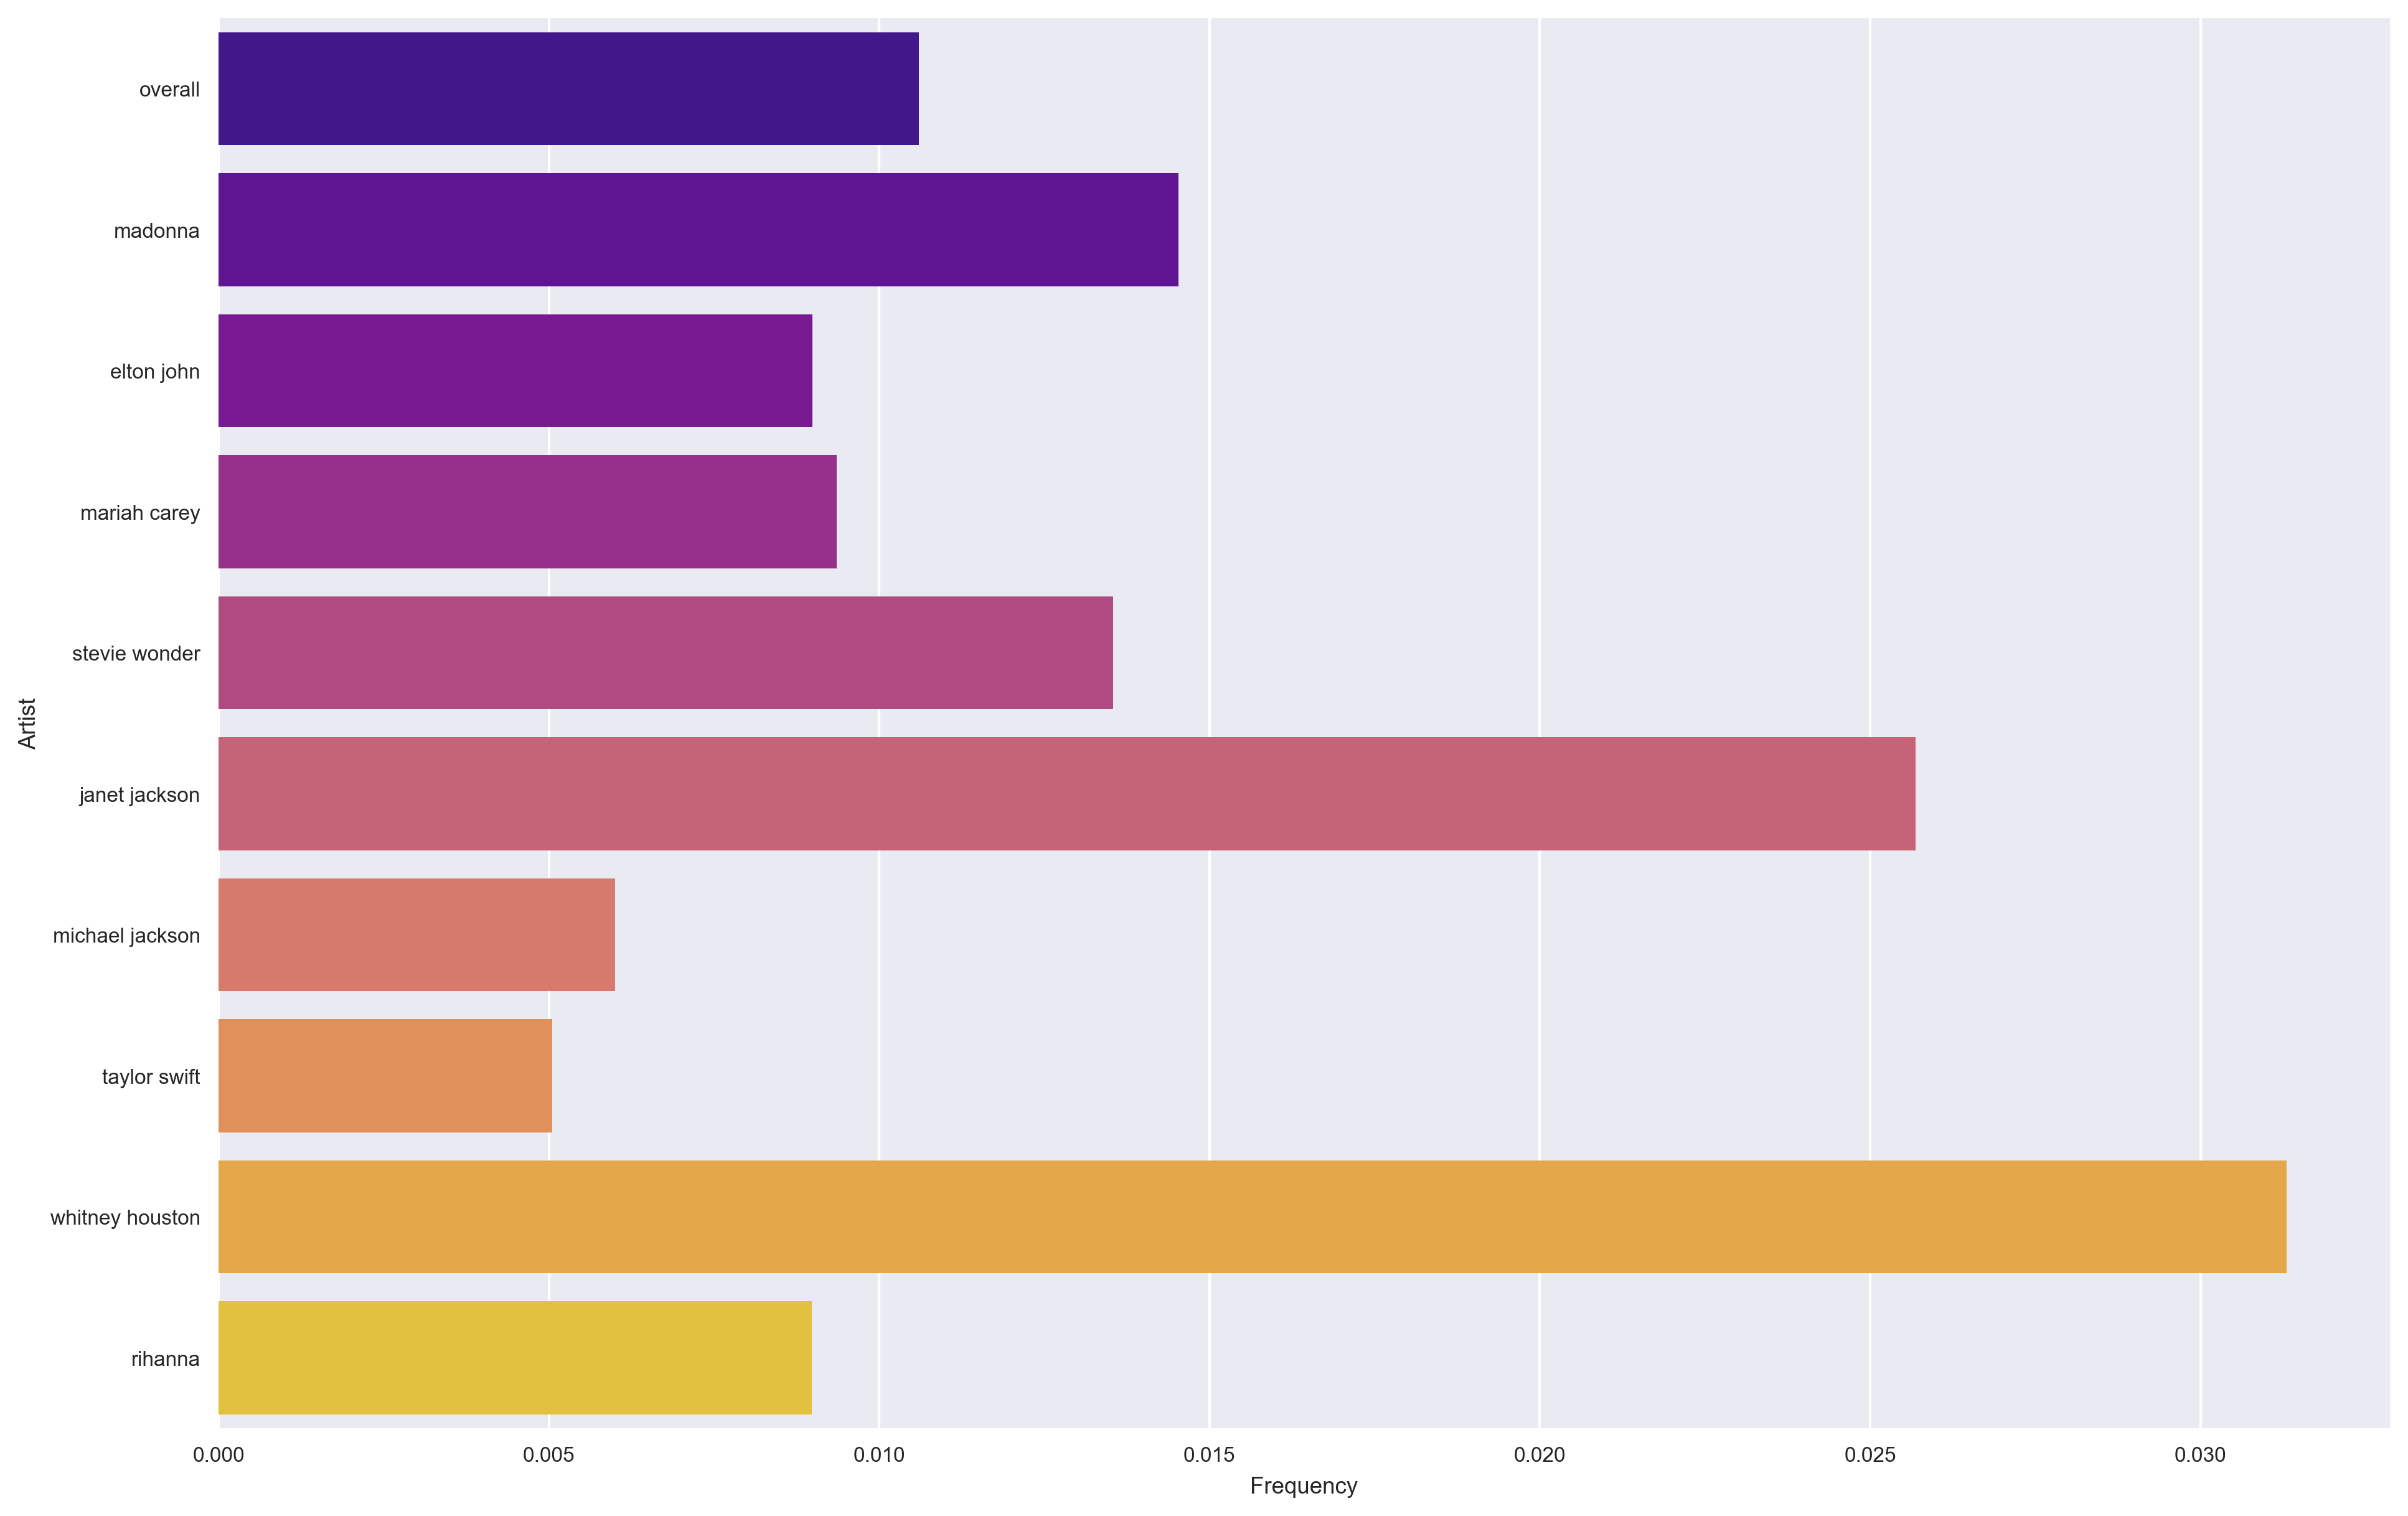

In [43]:
artist_table = pd.DataFrame(data={'Artist': artists_and_overall[:10], 'Frequency':top_artist_freq[:10]})
plt.subplots(dpi=300, figsize=(15, 10))
sns.set(font_scale=1.5)
sns.barplot(x = artist_table['Frequency'], y=artist_table['Artist'], palette=("plasma"));

As you can see, Madonna's songs don't have the highest frequency compared to other artists. Janet Jackson and Whitney Houston use love much more frequently in their songs than Madonna does. Surprisingly, Taylor Swift doesn't use the word 'love' that often, but, ***we all know her songs are about love***.

----

# Your favorite artist, their favorite words<a id='WORDS'></a>
Since I explored Madonna's most frequently used words, I decided to do that for all artists in the dataset. Below, I made an interactive function so that you can choose your artist and see which words they use the most frequently in their songs that made the Billboard Top 100!

**Note:** Some artists are "featured" and therefore are separate "artists" in the data even though they are the same artist.

In [42]:
#This wont show up in the HTML; must be run in ipynb file
def artist_top_20(artist):
    plt.subplots(dpi=300)
    sns.set(font_scale=.8)
    cvec = CountVectorizer(stop_words=stop)
    cv = cvec.fit_transform(only_w_lyrics[only_w_lyrics['Artist']==artist]['Lyrics'].values)
    cvfn = cvec.get_feature_names()
    sorted_words = sorted(list(zip(cvfn, np.asarray(cv.sum(axis=0)).ravel())), 
                               key=lambda x: x[1], reverse=True)
    words, count = [i[0] for i in sorted_words][:20], [i[1] for i in sorted_words][:20]
    top_words = pd.DataFrame(data={'Word' : words, 'Count': count}).take([1, 0], axis=1)
    plt.title('20 Most Frequently Used Words in Top Songs by '+ artist)
    sns.barplot(x = top_words['Count'], y=top_words['Word'], palette=("plasma"));
    
choose_your_artist = interact(artist_top_20, artist=np.unique(only_w_lyrics['Artist'].values));

A Jupyter Widget

----

That concludes my Billboard exploration project! Although I wasn't surprised to see that 'love' was a major topic of popular songs, I was quite surprised to see that the frequency of the word 'love' in popular songs has declined over the years. I think the most profound thing was how well the topic models captured the zeitgeist of a certain decade. I hope to continue this project and maybe use LDA instead of NMF to really optimize my topic models.

Since I almost exclusively listen to either classical or indie/alternative/psychedelic rock junk, Billboard songs are something a little foreign to me, so I'm glad I was able to go through the songs and lyrics and glean some information like a "Ray of Light" (Thanks Madonna).